<a href="https://colab.research.google.com/github/junhofly/python_DataAnaylsis_of_CORONA_Impact/blob/main/%EC%B5%9C%EC%A4%80%ED%98%B8_%EC%B5%9C%EC%A2%85_%EC%A4%80%EB%B9%84%EC%9E%90%EB%A3%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 코로나 발생 이전과 이후, 신용카드 소비내역 분석을 통한 소비증감 분석하기 
---

### 가설 
*  코로나 발생 이후 맞춤형 복지 신용카드 소비가 증가(또는 감소)했을 것이다.
*   공무원 복지카드 특성상 4-50대의 소비가 많을 것이다.
*   연휴 성수기가 포함된 여름(7,8월)과 겨울(12,1월)의 소비가 많을 것이다.
*   소비건수와 소비금액 간의 양의 상관관계가 있을 것이다.

### 01. Google Drive에 있는 데이터 가져오기 
---

- 먼저 해당 프로젝트가 구동되고 있는 가상머신에서 사용자의 구글드라이브로 mount하도록 한다

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 02. 라이브러리 import 및 글꼴 설정
---

In [1]:
import io  
import pandas as pd # 데이터 분석에 사용할 pandas
import numpy as np # 수치계산에 사용할 numpy
import seaborn as sns # 시각화를 위한 seaborn 
# > 많은 데이터에 대해선 처리 속도가 느리다.

"""
 파일 경로등을 활용하기 위해
"""
import glob
import os


- 데이터 도식화 관련 라이브러리 로드 및 한글 폰트 설정


In [2]:
# 그래프를 노트북안에 그리기위해
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

- 폰트 설치하기 (최초1회)

In [3]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

- 시스템에 있는 폰트 확인하기

In [ ]:
sys_font = fm.findSystemFonts()
print(f"sys_font number :  {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

sys_font number :  48
nanum_font number: 31


- 나눔 폰트 경로 확인하기

In [ ]:
nanum_font

['/usr/share/fonts/truetype/nanum/NanumGothicCoding-Bold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoExtraBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareRoundEB.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunpenR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoEcoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareR.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicUltraLight.ttf',
 '/usr/share/fonts/true

- 현재 설정되어 있는 폰트 사이즈와 글꼴 확인

In [4]:
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
current_font()

Python 3.7.11
설정 폰트 글꼴: ['sans-serif'], 설정 폰트 사이즈: 10.0


In [5]:
path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'  # 나눔바름고딕
#font_name = fm.FontProperties(fname=path, size=10).get_name()
font = fm.FontProperties(fname=path, size=9)
fm._rebuild()
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)

In [ ]:
# # Google Colab 사용시,
# # 해당 컨테이너에 나눔고딕 설치,
# !apt -qq -y install fonts-nanum > /dev/null

# import matplotlib.font_manager as fm

# fontpath = "/user/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
# font = fm.FontProperties(fname=fontpath, size = 10) 
# fm._rebuild()

# #Colab에서 도식에 한글 폰트 설정
# plt.rc("font", family="NanumGothic")
# # 마이너스 폰트 깨지는 문제 해결을 위해
# plt.rc("axes", unicode_minus=False)

### 03. Pandas 로 CSV 파일 읽어오기
---

In [ ]:
def data_load(path):
    # 예외처리는 호출시에 적용하기
    print(f"csv 데이터파일 로드... 경로: {path}")
    os.chdir(path)
    return sorted(glob.glob("*"))

def save_to_csv(df, savefile, encoding):
    try:
      df.to_csv(savefile, encoding = encoding)
      print(f"{savefile} 경로에 저장완료")
    except:
      print("저장 경로 오류")
    

#### 병합과정 최초 1회 실행
> 기준년도의 01월 부터 12월까지 별도로 쪼개진 csv파일들에 대해 병합하는 과정<br> `fileDirectory` : 여러 년도의 데이터가 담겨있는 상위 디렉토리 경로 지정<br> `fileName` : 특정 년도의 분할 csv 데이터가 담긴 디렉토리들을 리스트 형태로 선언 및 초기화<br> `year` : 병합할 연도 설정 <br> `savefile` : 병합된 csv파일을 저장할 경로 설정<br> `encoding` : pandas.to_csv() 함수에서 어떤 방식으로 encoding 할지 결정




##### - 2020.01~12 데이터 로드 및 CSV파일 병합(최초1회)

In [ ]:
#   ! 경로확인 필요 !

fileDirectory = "/content/drive/MyDrive/네이버부스트코스_3조/맞춤형복지_신용카드_소비내역정보_데이터/추가데이터_2019_2020/"
fileName = ["맞춤형복지_신용카드_소비내역정보_2019_여성", "맞춤형복지_신용카드_소비내역정보_2019_남성", "맞춤형복지_신용카드_소비내역정보_2020_여성", "맞춤형복지_신용카드_소비내역정보_2020_남성"]
year = 2020 
savefile = f"../../경로테스트_{year}.csv" 
encoding = "utf-8-sig"
kor_columns = ["번호", "업종명칭", "2차분류코드명", "2차분류코드", "성별", "사용연월", "1차분류코드명", "연령별", "월별소비번호", "사용금액", "사용건수", "1차분류코드"]

#   columns = ['Unnamed: 0', 'crdCoBzkNm', 'sndCtgyNm', 'sndCtgy', 'sxClNm', 'useYymm', 'fstCtgyNm', 'agePrd', 'no', 'crdUseAmt', 'crdUseCnt', 'fstCtgy']
#   fileName[0] : 2019_여성 csv 파일 경로 접근
#   fileName[1] : 2019_남성 csv 파일 경로 접근
#   fileName[2] : 2020_여성 csv 파일 경로 접근 
#   fileName[3] : 2020_남성 csv 파일 경로 접근


path_2020_F = fileDirectory + fileName[2]
path_2020_M = fileDirectory + fileName[3]
load_csvs = [] #  부모 디렉토리에서 하위 디렉토리내 csv파일을 load

try:
    load_csvs = data_load(path_2020_F)
except: 
    print("파일경로 로드 오류")


df_2020 = pd.read_csv(load_csvs[0])   # 사용하고자 하는 dataframe을 선택

#   01월 부터 12월까지 모든 데이터를 한 DataFrame으로 담기 위해서, 다음의 반복문을 거침
#   ignore_index=True를 통해 1년간의 데이터에 대해 번호를 붙여줄 수 있음.
i = 1
while i < len(load_csvs):
  df_2020 = df_2020.append(pd.read_csv(load_csvs[i]), ignore_index=True)
  i += 1

# 데이터 성별B 와 머지과정
i=0
try:
  load_csvs.clear
  load_csvs = data_load(path_2020_M)
except:
  print("파일경로 로드 오류")

while i < len(load_csvs):
  df_2020 = df_2020.append(pd.read_csv(load_csvs[i]), ignore_index=True)
  i += 1


df_2020.columns = kor_columns   # df_2020.columns = kor_columns 모든 Dataframe 을 다 구성하고 실행할 것 
print(df_2020.columns)

df_2020.sort_values("사용연월") # 특정 column 기준으로 정렬

save_to_csv(df_2020, savefile, encoding)  # 특정 파일경로로 csv파일 저장

##### - - 2019.01~12 데이터 로드 및 CSV파일 병합(최초1회)

In [ ]:
#  ! 경로확인 필요 !

fileDirectory = "/content/drive/MyDrive/네이버부스트코스_3조/맞춤형복지_신용카드_소비내역정보_데이터/추가데이터_2019_2020/" 
fileName = ["맞춤형복지_신용카드_소비내역정보_2019_여성", "맞춤형복지_신용카드_소비내역정보_2019_남성", "맞춤형복지_신용카드_소비내역정보_2020_여성", "맞춤형복지_신용카드_소비내역정보_2020_남성"]
year = 2019
savefile = f"../../경로테스트2_{year}.csv" 
encoding = "utf-8-sig"
kor_columns = ["번호", "업종명칭", "2차분류코드명", "2차분류코드", "성별", "사용연월", "1차분류코드명", "연령별", "월별소비번호", "사용금액", "사용건수", "1차분류코드"]

#   columns = ['Unnamed: 0', 'crdCoBzkNm', 'sndCtgyNm', 'sndCtgy', 'sxClNm', 'useYymm', 'fstCtgyNm', 'agePrd', 'no', 'crdUseAmt', 'crdUseCnt', 'fstCtgy']
#   fileName[0] : 2019_여성 csv 파일 경로 접근
#   fileName[1] : 2019_남성 csv 파일 경로 접근
#   fileName[2] : 2020_여성 csv 파일 경로 접근 
#   fileName[3] : 2020_남성 csv 파일 경로 접근

path_2019_F = fileDirectory + fileName[0]
path_2019_M = fileDirectory + fileName[1]
load_csvs = [] #  부모 디렉토리에서 하위 디렉토리내 csv파일을 load

try:
  load_csvs = data_load(path_2019_F)
except:
  print("파일경로 오류")


df_2019 = pd.read_csv(load_csvs[0])   # 사용하고자 하는 dataframe을 선택
#   01월 부터 12월까지 모든 데이터를 한 DataFrame으로 담기 위해서, 다음의 반복문을 거침
#   ignore_index=True를 통해 1년간의 데이터에 대해 번호를 붙여줄 수 있음.
i = 1
while i < len(load_csvs):
  df_2019 = df_2019.append(pd.read_csv(load_csvs[i]), ignore_index=True)
  i += 1

#   데이터 성별B 와 머지과정
i=0
try:
  load_csvs.clear 
  load_csvs = data_load(path_2019_M)
except:
  print("파일경로 오류")

while i < len(load_csvs):
  df_2019 = df_2019.append(pd.read_csv(load_csvs[i]), ignore_index=True)
  i += 1

df_2019.columns = kor_columns   # df_2020.columns = kor_columns 모든 Dataframe 을 다 구성하고 실행할 것 
print(df_2019.columns)

df_2019.sort_values("사용연월")   # 특정 column 기준으로 정렬

save_to_csv(df_2019, savefile, encoding)  # 특정 파일경로로 csv파일 저장

csv 데이터파일 로드... 경로: /content/drive/MyDrive/네이버부스트코스_3조/맞춤형복지_신용카드_소비내역정보_데이터/추가데이터_2019_2020/맞춤형복지_신용카드_소비내역정보_2019_여성
csv 데이터파일 로드... 경로: /content/drive/MyDrive/네이버부스트코스_3조/맞춤형복지_신용카드_소비내역정보_데이터/추가데이터_2019_2020/맞춤형복지_신용카드_소비내역정보_2019_남성
Index(['번호', '업종명칭', '2차분류코드명', '2차분류코드', '성별', '사용연월', '1차분류코드명', '연령별',
       '월별소비번호', '사용금액', '사용건수', '1차분류코드'],
      dtype='object')
../../경로테스트2_2019.csv 경로에 저장완료


### - **(병합 이후)** 통합데이터 Pandas Dataframe으로 로드하기

In [15]:
fileDirectory = "/content/drive/MyDrive/네이버부스트코스_3조/맞춤형복지_신용카드_소비내역정보_데이터/"
fileName = ["맞춤형복지_신용카드_소비내역_통합정보_2020.csv", "맞춤형복지_신용카드_소비내역_통합정보_2019.csv"]

filePath_2020 = fileDirectory + fileName[0]
filePath_2019 = fileDirectory + fileName[1]

df_total_2020 = pd.read_csv(filePath_2020)
df_total_2019 = pd.read_csv(filePath_2019)


### <b>(최종발표추가)</b> 추가 전처리 내용
- 중복된 columns drop 한 Dataframe 구성
- 소비연월 -> 연도, 월 정보로 split 하기
- 코로나 확진자 정보 담기


- 사용연월 -> 연도 / 월 로 나누기

In [16]:
df_total_2019_drop=df_total_2019.drop(["Unnamed: 0", "번호"], axis=1)

#df_total_2019_drop["연도"] = df_total_2019_drop["사용연월"].map(lambda x: re.split(r"2019", x))
df_total_2019_drop["연도"] = df_total_2019_drop["사용연월"].map(lambda x: int(str(x)[:4])) # int형에 대해 문자열 분리하려 하면 not subscriptable 에러뜸
df_total_2019_drop["월"] = df_total_2019_drop["사용연월"].map(lambda x: int(str(x)[4:]))

df_total_2019_drop.head(5)

,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드,연도,월
0,양식,가족식사,A01,여,201901,가정친화,0,1,34500,1,A,2019,1
1,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,2,50700,2,A,2019,1
2,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,3,186400,7,A,2019,1
3,일식 /생선회집,가족식사,A01,여,201901,가정친화,0,4,18400,1,A,2019,1
4,일식/생선회집,가족식사,A01,여,201901,가정친화,0,5,14000,1,A,2019,1


In [17]:
df_total_2020_drop=df_total_2020.drop(["Unnamed: 0", "번호"], axis=1)
df_total_2020_drop["연도"] = df_total_2020_drop["사용연월"].map(lambda x : int(str(x)[:4]))
df_total_2020_drop["월"] = df_total_2020_drop["사용연월"].map(lambda x : int(str(x)[4:]))
df_total_2020_drop.head(5)

,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드,연도,월
0,화 장 품,미용,D02,여,202001,여가생활,60대,1,5236863,50,D,2020,1
1,화장품,미용,D02,여,202001,여가생활,60대,2,27688132,347,D,2020,1
2,화장품점,미용,D02,여,202001,여가생활,60대,3,54082772,659,D,2020,1
3,PG택시,여행/교통,D04,여,202001,여가생활,60대,4,6600,2,D,2020,1
4,RF공항버스,여행/교통,D04,여,202001,여가생활,60대,5,33000,2,D,2020,1


- 연도, 월 나누고, 사용연도 col 제거

In [18]:
df_total = pd.concat([df_total_2019_drop, df_total_2020_drop]).drop(["사용연월"], axis=1) #default axis=0
df_total

,업종명칭,2차분류코드명,2차분류코드,성별,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드,연도,월
0,양식,가족식사,A01,여,가정친화,0,1,34500,1,A,2019,1
1,일반음식점 기타,가족식사,A01,여,가정친화,0,2,50700,2,A,2019,1
2,일반음식점 기타,가족식사,A01,여,가정친화,0,3,186400,7,A,2019,1
3,일식 /생선회집,가족식사,A01,여,가정친화,0,4,18400,1,A,2019,1
4,일식/생선회집,가족식사,A01,여,가정친화,0,5,14000,1,A,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...
98203,할인점/슈퍼마켓,생활편의시설(유통),D12,남,여가생활,80대,4107,17100,1,D,2020,12
98204,PG쇼핑몰,전자상거래,D13,남,여가생활,80대,4108,124300,3,D,2020,12
98205,전자상거래(안심클릭미적용),전자상거래,D13,남,여가생활,80대,4109,174800,3,D,2020,12
98206,전자상거래PG,전자상거래,D13,남,여가생활,80대,4110,236360,1,D,2020,12


#### 데이터 미리보기

In [ ]:
df_total_2019.head()

,Unnamed: 0,번호,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
0,0,0,양식,가족식사,A01,여,201901,가정친화,0,1,34500,1,A
1,1,1,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,2,50700,2,A
2,2,2,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,3,186400,7,A
3,3,3,일식 /생선회집,가족식사,A01,여,201901,가정친화,0,4,18400,1,A
4,4,4,일식/생선회집,가족식사,A01,여,201901,가정친화,0,5,14000,1,A


In [ ]:
df_total_2019.tail()

,Unnamed: 0,번호,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
98272,98272,4079,공연장/전시장,오락/문화/관람,D08,남,201912,여가생활,30대,4080,21311345,822,D
98273,98273,4080,관람종합,오락/문화/관람,D08,남,201912,여가생활,30대,4081,2174750,251,D
98274,98274,4081,기타 오락.휴식시설,오락/문화/관람,D08,남,201912,여가생활,30대,4082,8973246,1160,D
98275,98275,4082,기타 복지문화,오락/문화/관람,D08,남,201912,여가생활,30대,4083,1227500,98,D
98276,98276,4083,기타입장료,오락/문화/관람,D08,남,201912,여가생활,30대,4084,5643371,342,D


In [ ]:
#df_total_2019 중복 열 삭제
df_total_2019_drop=df_total_2019.drop(["Unnamed: 0", "번호"], axis=1)
df_total_2019_drop

,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
0,양식,가족식사,A01,여,201901,가정친화,0,1,34500,1,A
1,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,2,50700,2,A
2,일반음식점 기타,가족식사,A01,여,201901,가정친화,0,3,186400,7,A
3,일식 /생선회집,가족식사,A01,여,201901,가정친화,0,4,18400,1,A
4,일식/생선회집,가족식사,A01,여,201901,가정친화,0,5,14000,1,A
...,...,...,...,...,...,...,...,...,...,...,...
98272,공연장/전시장,오락/문화/관람,D08,남,201912,여가생활,30대,4080,21311345,822,D
98273,관람종합,오락/문화/관람,D08,남,201912,여가생활,30대,4081,2174750,251,D
98274,기타 오락.휴식시설,오락/문화/관람,D08,남,201912,여가생활,30대,4082,8973246,1160,D
98275,기타 복지문화,오락/문화/관람,D08,남,201912,여가생활,30대,4083,1227500,98,D


In [ ]:
#df_total_2020 중복 열 삭제
df_total_2020_drop=df_total_2020.drop(["Unnamed: 0", "번호"], axis=1)
df_total_2020_drop

,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
0,화 장 품,미용,D02,여,202001,여가생활,60대,1,5236863,50,D
1,화장품,미용,D02,여,202001,여가생활,60대,2,27688132,347,D
2,화장품점,미용,D02,여,202001,여가생활,60대,3,54082772,659,D
3,PG택시,여행/교통,D04,여,202001,여가생활,60대,4,6600,2,D
4,RF공항버스,여행/교통,D04,여,202001,여가생활,60대,5,33000,2,D
...,...,...,...,...,...,...,...,...,...,...,...
98203,할인점/슈퍼마켓,생활편의시설(유통),D12,남,202012,여가생활,80대,4107,17100,1,D
98204,PG쇼핑몰,전자상거래,D13,남,202012,여가생활,80대,4108,124300,3,D
98205,전자상거래(안심클릭미적용),전자상거래,D13,남,202012,여가생활,80대,4109,174800,3,D
98206,전자상거래PG,전자상거래,D13,남,202012,여가생활,80대,4110,236360,1,D


In [ ]:
df_total_2019_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98277 entries, 0 to 98276
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   업종명칭     98277 non-null  object
 1   2차분류코드명  98277 non-null  object
 2   2차분류코드   98277 non-null  object
 3   성별       98277 non-null  object
 4   사용연월     98277 non-null  int64 
 5   1차분류코드명  98277 non-null  object
 6   연령별      98277 non-null  object
 7   월별소비번호   98277 non-null  int64 
 8   사용금액     98277 non-null  int64 
 9   사용건수     98277 non-null  int64 
 10  1차분류코드   98277 non-null  object
dtypes: int64(4), object(7)
memory usage: 8.2+ MB


In [ ]:
df_total_2019_drop.columns

Index(['업종명칭', '2차분류코드명', '2차분류코드', '성별', '사용연월', '1차분류코드명', '연령별', '월별소비번호',
       '사용금액', '사용건수', '1차분류코드'],
      dtype='object')

In [ ]:
df_total_2019_drop.dtypes

업종명칭       object
2차분류코드명    object
2차분류코드     object
성별         object
사용연월        int64
1차분류코드명    object
연령별        object
월별소비번호      int64
사용금액        int64
사용건수        int64
1차분류코드     object
dtype: object

### 04. 데이터 결측치 확인
---

In [ ]:
df_total_2019.isnull()

,Unnamed: 0,번호,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98272,False,False,False,False,False,False,False,False,False,False,False,False,False
98273,False,False,False,False,False,False,False,False,False,False,False,False,False
98274,False,False,False,False,False,False,False,False,False,False,False,False,False
98275,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
null_count_2019=df_total_2019.isnull().sum()
null_count_2019

Unnamed: 0    0
번호            0
업종명칭          0
2차분류코드명       0
2차분류코드        0
성별            0
사용연월          0
1차분류코드명       0
연령별           0
월별소비번호        0
사용금액          0
사용건수          0
1차분류코드        0
dtype: int64

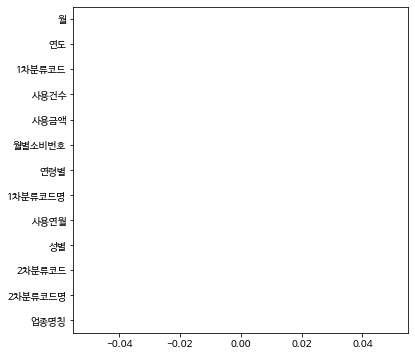

In [ ]:
df_total_2019_drop.isnull().sum().plot.barh(figsize=(6,6))

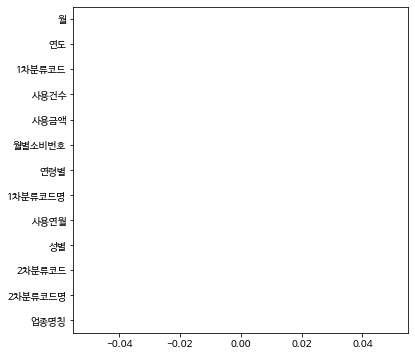

In [ ]:
df_total_2020_drop.isnull().sum().plot.barh(figsize=(6,6))

### 05. 데이터 시각화
---

#### <b> I. 소비 업종별 세부 시각화</b>
- 1차분류코드 기준 
  - ['가정친화', '건강관리', '자기계발', '여가생활', '온누리상품권', '온누리(지역사랑)상품권']

- 2차분류코드명 기준 
  - 2019 년 ['가족식사', '음료/식품', '가전제품', '컴퓨터/통신', '의류/잡화', '병의원진료', '약국및의료기기구매', '학원수강', '학습자재/도서구매', '미용', '여행/교통', '숙박시설', '취미생활', '오락/문화/관람', '생활편의시설(유통)', '전자상거래', '운송/임대', '용역서비스', '생활용품', '가구/인테리어/건축자재', '자녀보육', '차량서비스/차량연료', '결혼/장례서비스지원', '기부금', '제조/도매업관리', '선물용품', '건강식품', '보험/금융', '레저/스포츠', '여가활용', '기념품', '공예/토산품', '관광(외국인전용점)', '온누리상품권(개인구매)', '유아용품', '온누리(지역사랑)(개인구매)']

  - 2020년 ['미용', '여행/교통', '숙박시설', '여가활용', '취미생활', '오락/문화/관람', '운송/임대', '용역서비스', '가족식사', '음료/식품', '가전제품', '컴퓨터/통신', '생활용품', '가구/인테리어/건축자재', '의류/잡화', '차량서비스/차량연료', '결혼/장례서비스지원', '제조/도매업관리', '병의원진료', '약국및의료기기구매', '건강식품', '보험/금융', '학습자재/도서구매', '레저/스포츠', '공예/토산품', '생활편의시설(유통)', '전자상거래', '기념품', '자녀보육', '기부금', '선물용품', '학원수강', '관광(외국인전용점)', '온누리(지역사랑)(개인구매)', '유아용품']


##### - 소비업종 1, 2차분류코드명 데이터 확인

In [ ]:
print (df_total_2019_drop["1차분류코드명"].unique().tolist())
print (df_total_2020_drop["1차분류코드명"].unique().tolist())

['가정친화', '건강관리', '자기계발', '여가생활', '온누리상품권', '온누리(지역사랑)상품권']
['여가생활', '가정친화', '건강관리', '자기계발', '온누리(지역사랑)상품권']


In [ ]:
print (df_total_2019_drop["2차분류코드명"].nunique())
print (df_total_2019_drop["2차분류코드명"].unique().tolist())
print (df_total_2020_drop["2차분류코드명"].nunique())
print (df_total_2020_drop["2차분류코드명"].unique().tolist())

36
['가족식사', '음료/식품', '가전제품', '컴퓨터/통신', '의류/잡화', '병의원진료', '약국및의료기기구매', '학원수강', '학습자재/도서구매', '미용', '여행/교통', '숙박시설', '취미생활', '오락/문화/관람', '생활편의시설(유통)', '전자상거래', '운송/임대', '용역서비스', '생활용품', '가구/인테리어/건축자재', '자녀보육', '차량서비스/차량연료', '결혼/장례서비스지원', '기부금', '제조/도매업관리', '선물용품', '건강식품', '보험/금융', '레저/스포츠', '여가활용', '기념품', '공예/토산품', '관광(외국인전용점)', '온누리상품권(개인구매)', '유아용품', '온누리(지역사랑)(개인구매)']
35
['미용', '여행/교통', '숙박시설', '여가활용', '취미생활', '오락/문화/관람', '운송/임대', '용역서비스', '가족식사', '음료/식품', '가전제품', '컴퓨터/통신', '생활용품', '가구/인테리어/건축자재', '의류/잡화', '차량서비스/차량연료', '결혼/장례서비스지원', '제조/도매업관리', '병의원진료', '약국및의료기기구매', '건강식품', '보험/금융', '학습자재/도서구매', '레저/스포츠', '공예/토산품', '생활편의시설(유통)', '전자상거래', '기념품', '자녀보육', '기부금', '선물용품', '학원수강', '관광(외국인전용점)', '온누리(지역사랑)(개인구매)', '유아용품']


In [ ]:
df_total_2019_drop["1차분류코드명"].value_counts()

가정친화            41416
여가생활            40655
건강관리            10759
자기계발             5371
온누리(지역사랑)상품권       69
온누리상품권              7
Name: 1차분류코드명, dtype: int64

##### - A. 소비업종 1차분류코드명별 사용건수 현황

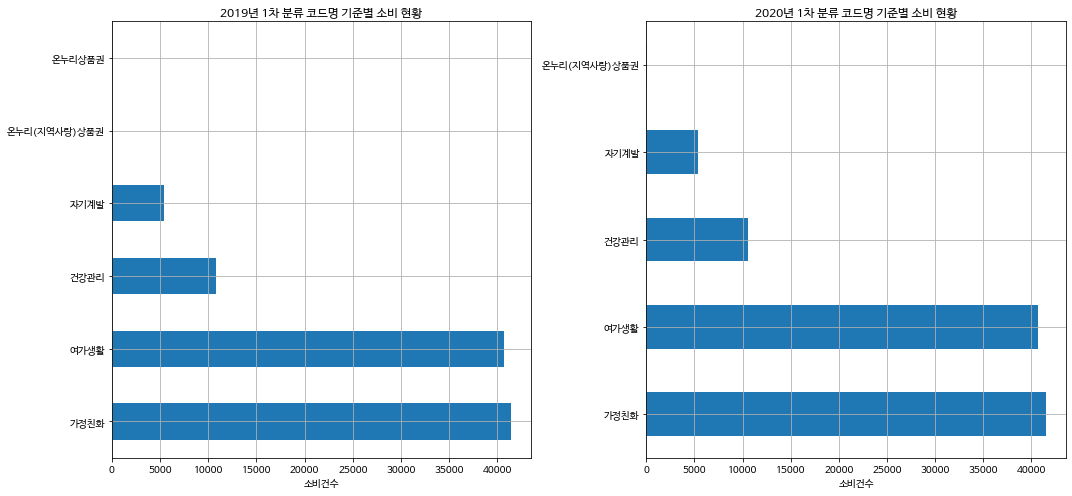

In [ ]:
# 1차분류코드 기준으로 소비건수에 대해 소비현황을 시각화
plt.subplot(1,2,1)
df_total_2019_drop["1차분류코드명"].value_counts().plot.barh(figsize=(15,7), grid=True, rot=0)
plt.xlabel("소비건수")
plt.title("2019년 1차 분류 코드명 기준별 소비 현황")
plt.subplot(1,2,2)
df_total_2020_drop["1차분류코드명"].value_counts().plot.barh(figsize=(15,7), grid=True, rot=0)
plt.xlabel("소비건수")
plt.title("2020년 1차 분류 코드명 기준별 소비 현황")

plt.tight_layout()
plt.show()

##### -  B. 소비업종 2차분류코드명별 사용건수 현황

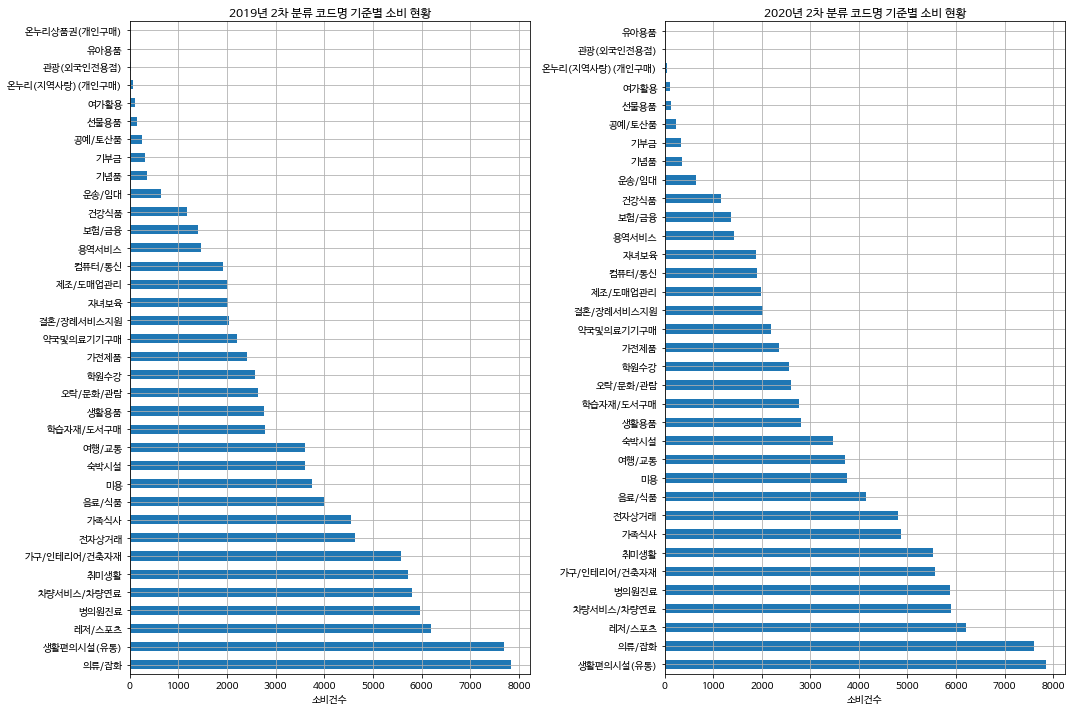

In [ ]:
# 1차분류코드 기준으로 소비건수에 대해 소비현황을 시각화
plt.subplot(1,2,1)
df_total_2019_drop["2차분류코드명"].value_counts().plot.barh(figsize=(15,10), grid=True, rot=0)
plt.xlabel("소비건수")
plt.title("2019년 2차 분류 코드명 기준별 소비 현황")
plt.subplot(1,2,2)
df_total_2020_drop["2차분류코드명"].value_counts().plot.barh(figsize=(15,10), grid=True, rot=0)
plt.xlabel("소비건수")
plt.title("2020년 2차 분류 코드명 기준별 소비 현황")

plt.tight_layout()
plt.show()


In [ ]:
# df_total_2019_drop["2차분류코드명"].value_counts().plot.pie(figsize=(10,10),autopct='%1.1f%%')

In [ ]:
# df_total_2020_drop["1차분류코드명"].value_counts()

In [ ]:
# df_total_2020_drop["1차분류코드명"].value_counts().plot.barh(figsize=(8,7), grid=True, rot=0)

In [ ]:
# df_total_2020_drop["2차분류코드명"].value_counts().plot.barh(figsize=(8,10), grid=True, rot=0)

In [ ]:
# df_total_2020_drop["2차분류코드명"].value_counts().plot.pie(figsize=(10,10),autopct='%1.1f%%')

##### C. 2019년 상위 10개 사용건수 변화 시각화

- 전처리 과정

In [ ]:
df_top_cnt_2019 = df_total_2019_drop.pivot_table(index="2차분류코드명", values="사용건수", aggfunc="count").sort_values(by=["사용건수"], ascending=False)[:10]
df_top_cnt_2019 = df_top_cnt_2019.transpose()

top_10 = df_top_cnt_2019.columns.tolist()

df_top_cnt_2020 = df_total_2020.pivot_table(index="2차분류코드명", values="사용건수", aggfunc="count")
df_top_cnt_2020 = df_top_cnt_2020.transpose()
df_top_cnt_2020 = df_top_cnt_2020[top_10]
df_top_cnt_2020

2차분류코드명,의류/잡화,생활편의시설(유통),레저/스포츠,병의원진료,차량서비스/차량연료,취미생활,가구/인테리어/건축자재,전자상거래,가족식사,음료/식품
사용건수,7604,7849,6210,5867,5891,5535,5561,4803,4874,4149


- 시각화 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


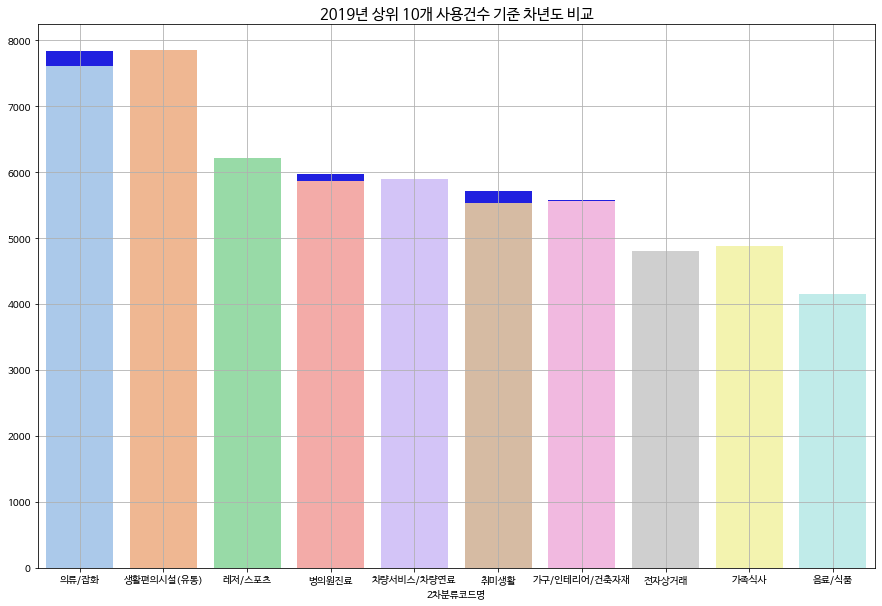

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.title("2019년 상위 10개 사용건수 기준 차년도 비교", fontsize=15)
ax = fig.add_subplot(1,1,1)
ax = sns.barplot(data=df_top_cnt_2019, color="b")
ax = sns.barplot(data=df_top_cnt_2020, palette="pastel")
plt.grid()
plt.show()

##### D. 상위10개 소비 품목 사용 금액 변화 시각화

- 2차분류코드명별 소비 금액 합산 기준


In [ ]:
#df_top_2019 = df_total_2019_drop.groupby(["2차분류코드명"])["사용건수"].count()
df_top_sum_2019 = df_total_2019_drop.pivot_table(index="2차분류코드명", values="사용금액", aggfunc="sum").sort_values(by=["사용금액"], ascending=False)[:10]
df_top_sum_2019 = df_top_sum_2019.transpose()
top_10 = df_top_sum_2019.columns.tolist()

df_top_sum_2020 = df_total_2020.pivot_table(index="2차분류코드명", values="사용금액", aggfunc="sum")
df_top_sum_2020 = df_top_sum_2020.transpose()
df_top_sum_2020 = df_top_sum_2020[top_10]


#df_top_sum_2019.rename(index={"사용금액":"2019 사용금액"},inplace=True)
#df_top_sum_2020.rename(index={"사용금액":"2020 사용금액"},inplace=True)

#df_top_sum = pd.concat([df_top_sum_2019, df_top_sum_2020]) #default axis=0
#df_top_sum=df_top_sum.transpose()
#df_top_sum

,2019 사용금액,2020 사용금액
2차분류코드명,,
전자상거래,1824197268329,2220485279396
생활편의시설(유통),1283665262021,1171545645032
가족식사,982419260854,771936706706
병의원진료,548822699293,525630919168
차량서비스/차량연료,452386832817,381149832697
보험/금융,316814915933,270062540077
여행/교통,308971745543,138285392266
음료/식품,211044412748,208666735322
학원수강,206757069438,171388688493


- 시각화

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


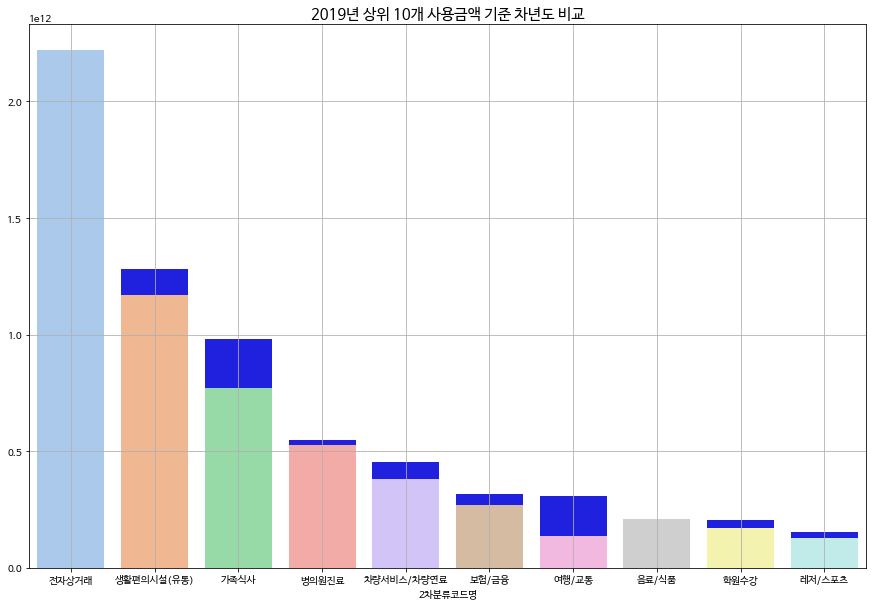

In [ ]:
fig = plt.figure(figsize=(15,10))
plt.title("2019년 상위 10개 사용금액 기준 차년도 비교", fontsize=15)
ax = fig.add_subplot(1,1,1)
ax = sns.barplot(data=df_top_sum_2019, color="b",)
ax = sns.barplot(data=df_top_sum_2020, palette="pastel")
plt.grid()
# plt.legend()
plt.show()

소비업종 1차분류코드명별 2차분류코드명(상위항목별 하위목록)

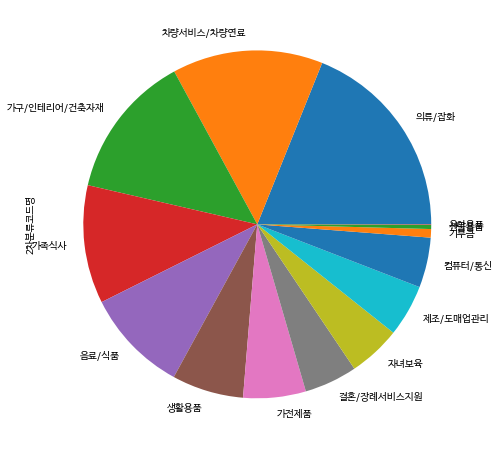

In [ ]:
# 가정친화
df_total_2019_drop.loc[df_total_2019_drop["1차분류코드명"] == "가정친화"
         ,"2차분류코드명"].value_counts().plot.pie(figsize=(8,8))

# 여가생활
# df_total_2019_drop.loc[df_total_2019_drop["1차분류코드명"] == "여가생활"
#          ,"2차분류코드명"].value_counts().plot.pie(figsize=(8,8))

# 건강관리
# df_total_2019_drop.loc[df_total_2019_drop["1차분류코드명"] == "건강관리"
#         ,"2차분류코드명"].value_counts().plot.pie(figsize=(7,7))

# 자기계발
# df_total_2019_drop.loc[df_total_2019_drop["1차분류코드명"] == "자기계발"
#         ,"2차분류코드명"].value_counts().plot.pie(figsize=(7,7))

# 온누리 상품권
# df_total_2019_drop.loc[df_total_2019_drop["1차분류코드명"] == "온누리(지역사랑)상품권"

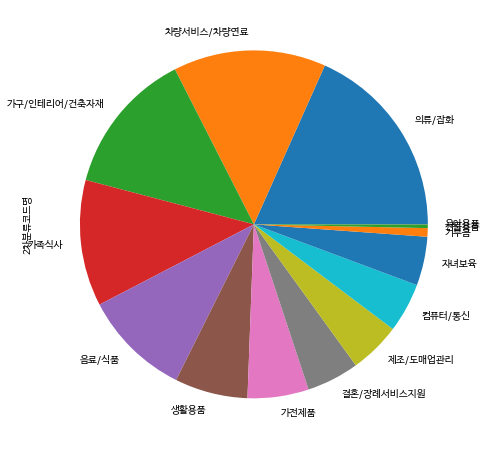

In [ ]:
# 가정친화
df_total_2020_drop.loc[df_total_2020_drop["1차분류코드명"] == "가정친화"
         ,"2차분류코드명"].value_counts().plot.pie(figsize=(8,8))

# 여가생활
# df_total_2020_drop.loc[df_total_2020_drop["1차분류코드명"] == "여가생활"
#          ,"2차분류코드명"].value_counts().plot.pie(figsize=(8,8))

# 건강관리
# df_total_2020_drop.loc[df_total_2020_drop["1차분류코드명"] == "건강관리"
#         ,"2차분류코드명"].value_counts().plot.pie(figsize=(7,7))

# 자기계발
# df_total_2020_drop.loc[df_total_2020_drop["1차분류코드명"] == "자기계발"
#         ,"2차분류코드명"].value_counts().plot.pie(figsize=(7,7))

# 온누리 상품권
# df_total_2020_drop.loc[df_total_2020_drop["1차분류코드명"] == "온누리(지역사랑)상품권"

##### 연령대별


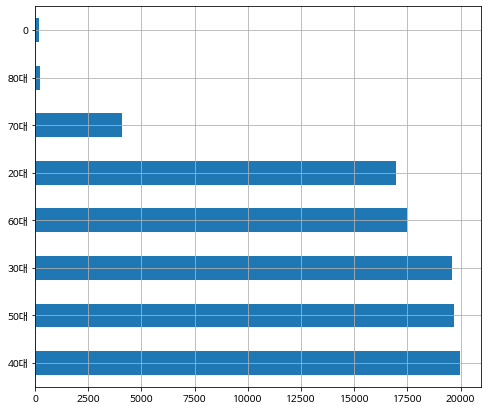

In [ ]:
df_total_2019_drop["연령별"].value_counts().plot.barh(figsize=(8,7), grid=True, rot=0)

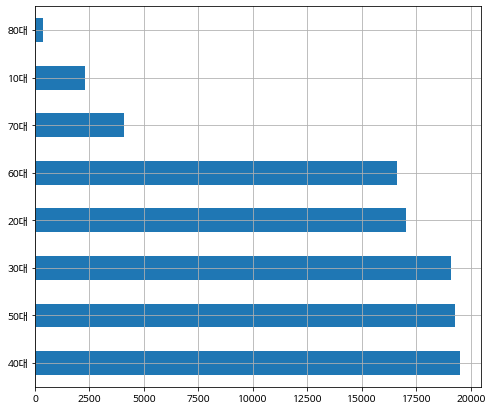

In [ ]:
df_total_2020_drop["연령별"].value_counts().plot.barh(figsize=(8,7), grid=True, rot=0)

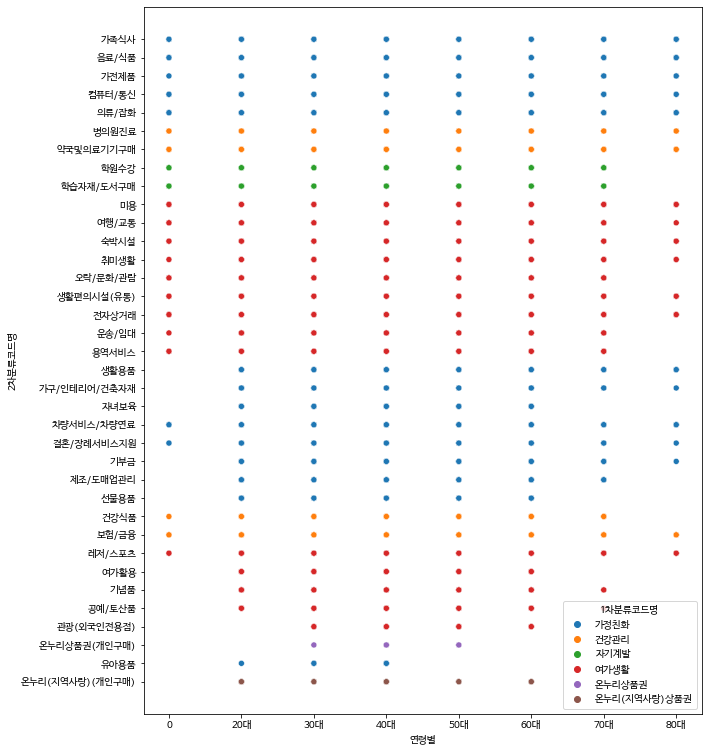

In [ ]:
plt.figure(figsize=(10,13))
sns.scatterplot(data=df_total_2019_drop, x="연령별", y="2차분류코드명" ,hue="1차분류코드명")

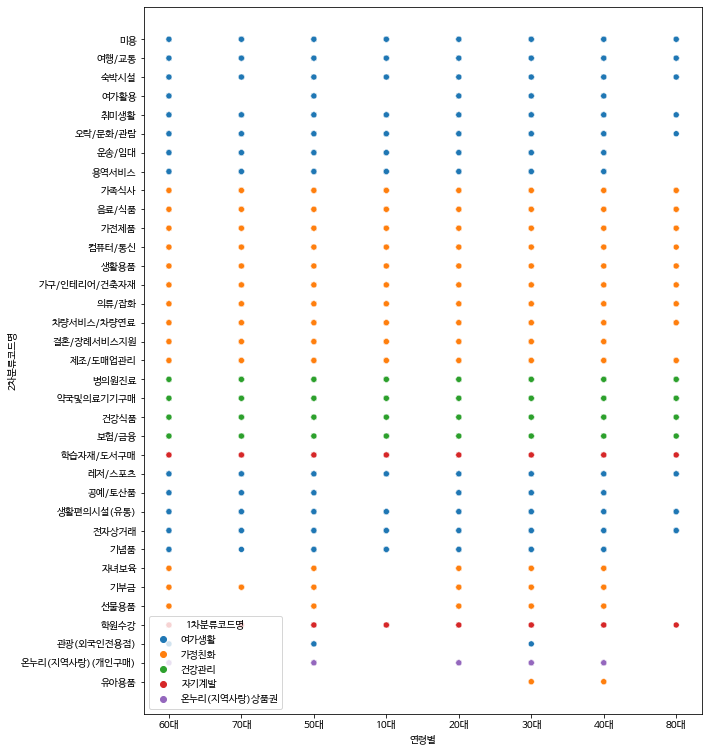

In [ ]:
plt.figure(figsize=(10,13))
sns.scatterplot(data=df_total_2020_drop, x="연령별", y="2차분류코드명" ,hue="1차분류코드명")

연령대별 특정 항목


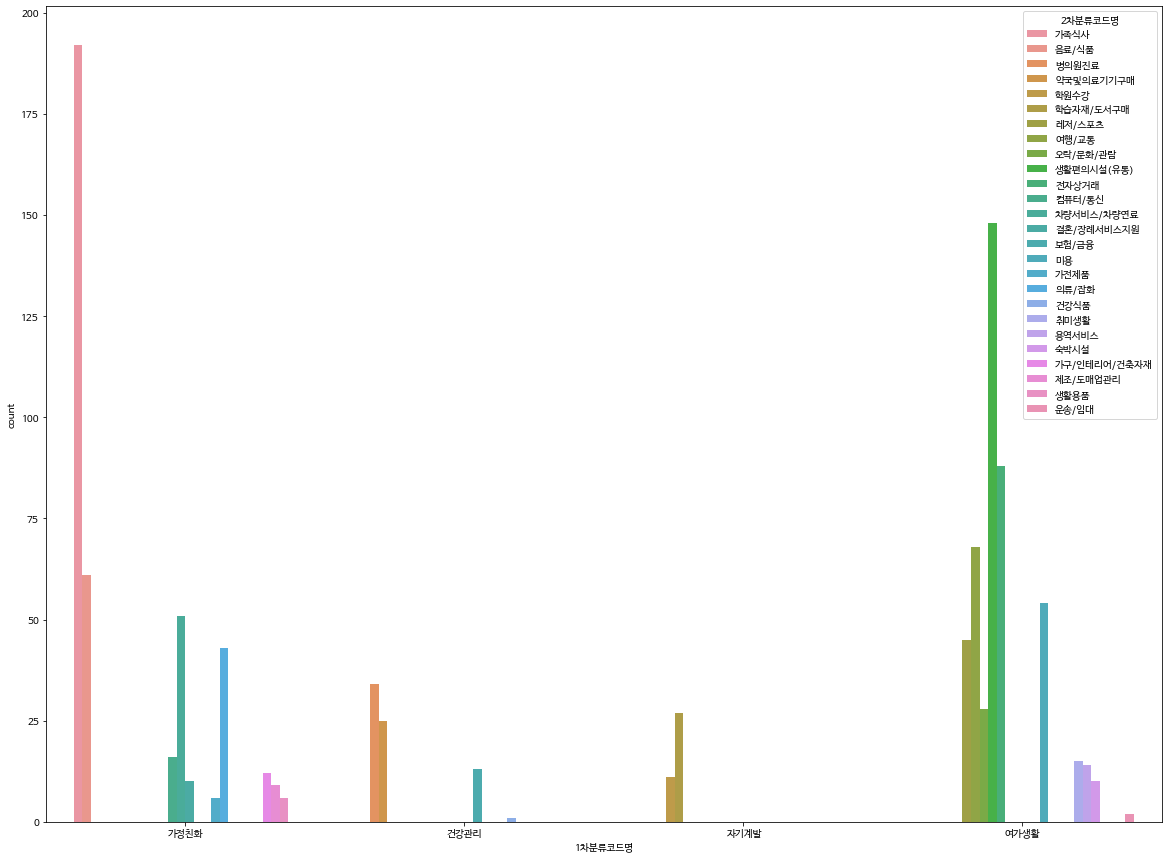

In [ ]:
# 10대 남자
# 변수 명과 10대 부분만 다른 연령으로 바꾸면 다른 연령 시각화 가능

df_남_10대 = df_total_2020_drop[(df_total_2020_drop["성별"]=="남") & (df_total_2020_drop["연령별"]=="10대")]

plt.figure(figsize=(20,15))
sns.countplot(data=df_남_10대, x="1차분류코드명",hue="2차분류코드명")

##### 특정 데이터 요약

1차분류코드

In [ ]:
df_total_2019_drop[df_total_2019_drop["1차분류코드명"]=="자기계발"]

,업종명칭,2차분류코드명,2차분류코드,성별,사용연월,1차분류코드명,연령별,월별소비번호,사용금액,사용건수,1차분류코드
28,일반전문학원,학원수강,C01,여,201901,자기계발,0,29,150700,1,C
29,문구용품,학습자재/도서구매,C02,여,201901,자기계발,0,30,7300,2,C
30,문방구점,학습자재/도서구매,C02,여,201901,자기계발,0,31,5500,2,C
31,서적,학습자재/도서구매,C02,여,201901,자기계발,0,32,34000,2,C
467,기능학원,학원수강,C01,여,201901,자기계발,20대,468,8386600,35,C
...,...,...,...,...,...,...,...,...,...,...,...
98073,일반 서적,학습자재/도서구매,C02,남,201912,자기계발,30대,3881,8876693,403,C
98074,전문 서적,학습자재/도서구매,C02,남,201912,자기계발,30대,3882,1931320,19,C
98075,정기간행물,학습자재/도서구매,C02,남,201912,자기계발,30대,3883,195000,1,C
98076,학습지,학습자재/도서구매,C02,남,201912,자기계발,30대,3884,27991870,384,C


In [ ]:
df_total_2019_drop.loc[df_total_2019["1차분류코드명"]=="자기계발",["연령별"]]

,연령별
28,0
29,0
30,0
31,0
467,20대
...,...
98073,30대
98074,30대
98075,30대
98076,30대


In [ ]:
df_total_2019_drop.loc[df_total_2019["1차분류코드명"]=="자기계발",["연령별"]].value_counts()

연령별
40대    1150
50대    1137
30대    1118
20대     950
60대     919
70대      85
0        12
dtype: int64

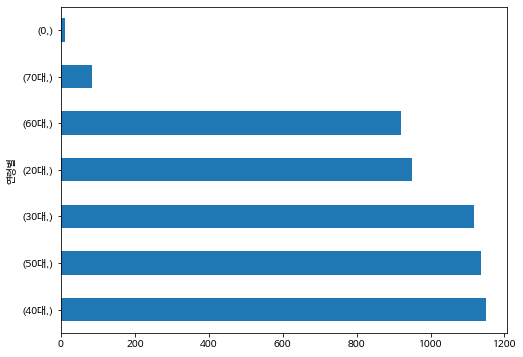

In [ ]:
df_total_2019_drop.loc[df_total_2019["1차분류코드명"]=="자기계발",["연령별"]].value_counts().plot.barh(figsize=(8,6))

2차분류코드

In [ ]:
cstore=df_total_2019_drop["2차분류코드명"]=="생활편의시설(유통)"

df_total_2019_drop.loc[cstore,["연령별"]]
cstore_age=df_total_2019_drop.loc[cstore,["연령별"]].value_counts()
cstore_age

연령별
40대    1452
50대    1439
30대    1439
60대    1372
20대    1354
70대     546
80대      52
0        28
dtype: int64

Text(0.5, 1.0, '생활편의시설(유통)의 연령대')

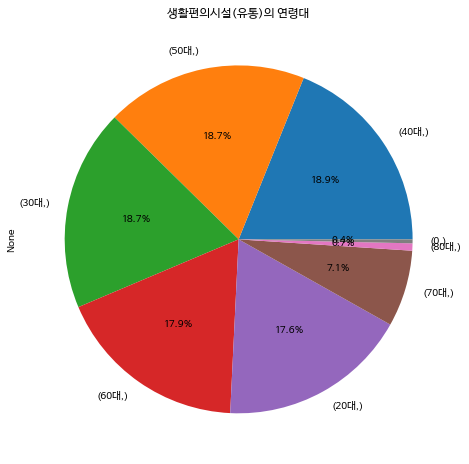

In [ ]:
cstore_age.plot.pie(figsize=(8,8),autopct='%1.1f%%')
plt.title("생활편의시설(유통)의 연령대")

In [ ]:
fs=df_total_2020_drop["2차분류코드명"]=="의류/잡화"

df_total_2020_drop.loc[fs,["연령별"]]
fs_age=df_total_2020_drop.loc[cstore,["연령별"]].value_counts()
fs_age

연령별
50대    1625
30대    1480
40대    1342
60대    1286
20대    1224
10대     450
70대     258
80대      17
dtype: int64

Text(0.5, 1.0, '의류/잡화의 연령대')

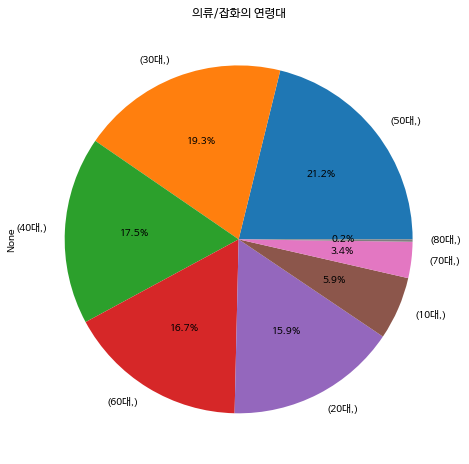

In [ ]:
fs_age.plot.pie(figsize=(8,8),autopct='%1.1f%%')
plt.title("의류/잡화의 연령대")

##### 수치형변수 히스토그램


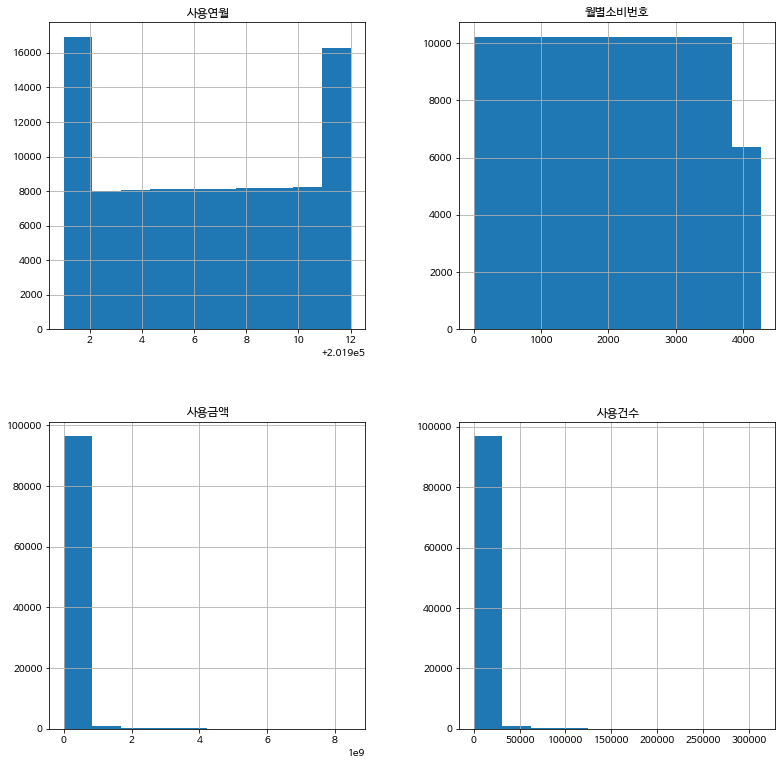

In [ ]:
h_2019=df_total_2019_drop.hist(figsize=(13,13))

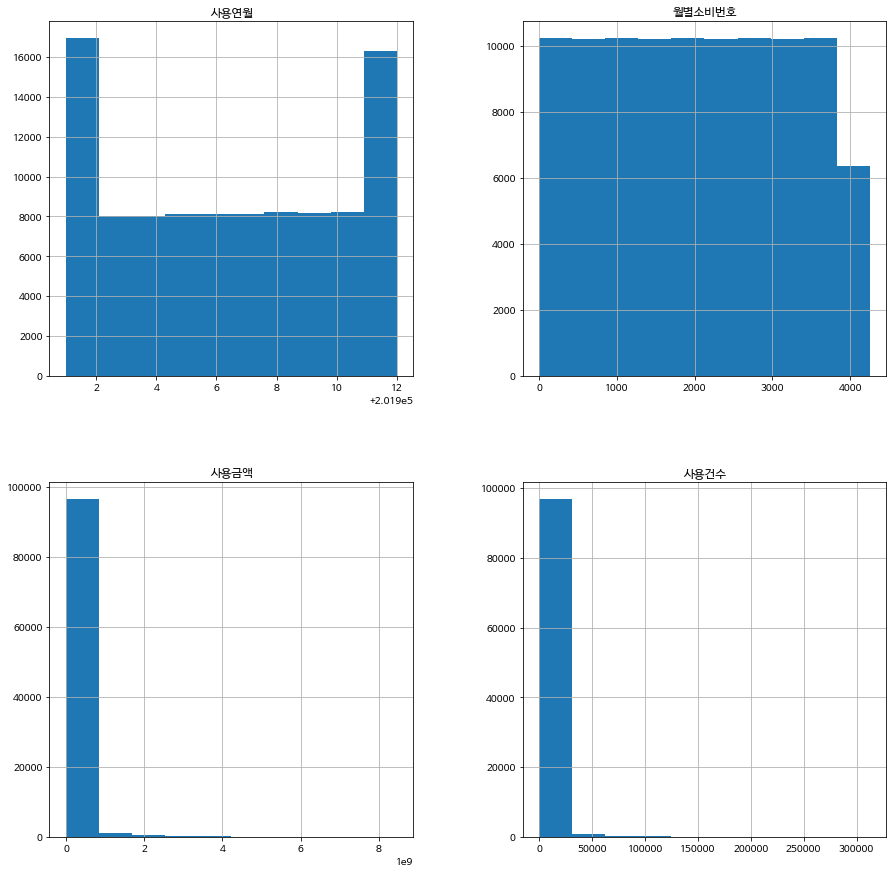

In [ ]:
h_2019=df_total_2019_drop.hist(figsize=(15,15))

#### II. 코로나 발생 이전(2019년)과 이후(2020년) 연령대, 성별, 월별 평균 사용금액 비교
---

연도별 사용금액 및 사용건수

In [ ]:
df_total_2019_drop[["사용금액","사용건수"]].describe()

,사용금액,사용건수
count,9.827700e+04,98277.000000
mean,7.340233e+07,2082.555186
std,3.393470e+08,10413.501175
min,3.000000e+01,1.000000
25%,5.178000e+05,10.000000
50%,3.851299e+06,71.000000
75%,2.386942e+07,495.000000
max,8.464331e+09,312666.000000


In [ ]:
df_total_2020_drop[["사용금액","사용건수"]].describe()

,사용금액,사용건수
count,9.820800e+04,98208.000000
mean,6.920757e+07,1909.894357
std,3.453337e+08,10020.614351
min,4.000000e+01,1.000000
25%,3.936000e+05,8.000000
50%,2.893052e+06,52.000000
75%,1.879578e+07,355.000000
max,9.992119e+09,289036.000000


##### A. 2019년 2020년 `연령대`별 소비현황






###### - 2019년 2020년 연령대별 평균 사용금액  

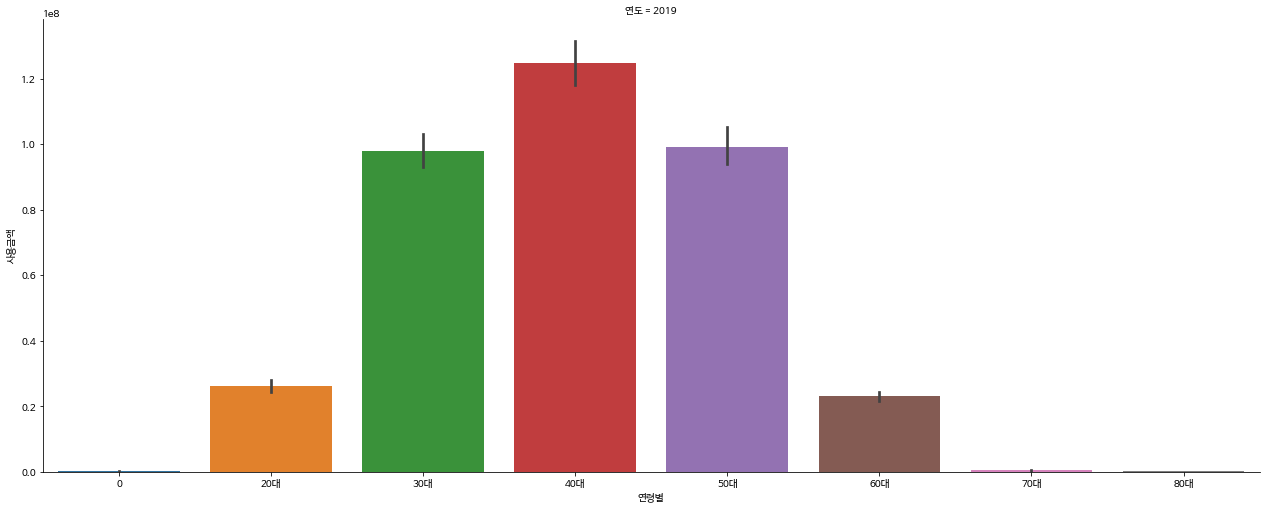

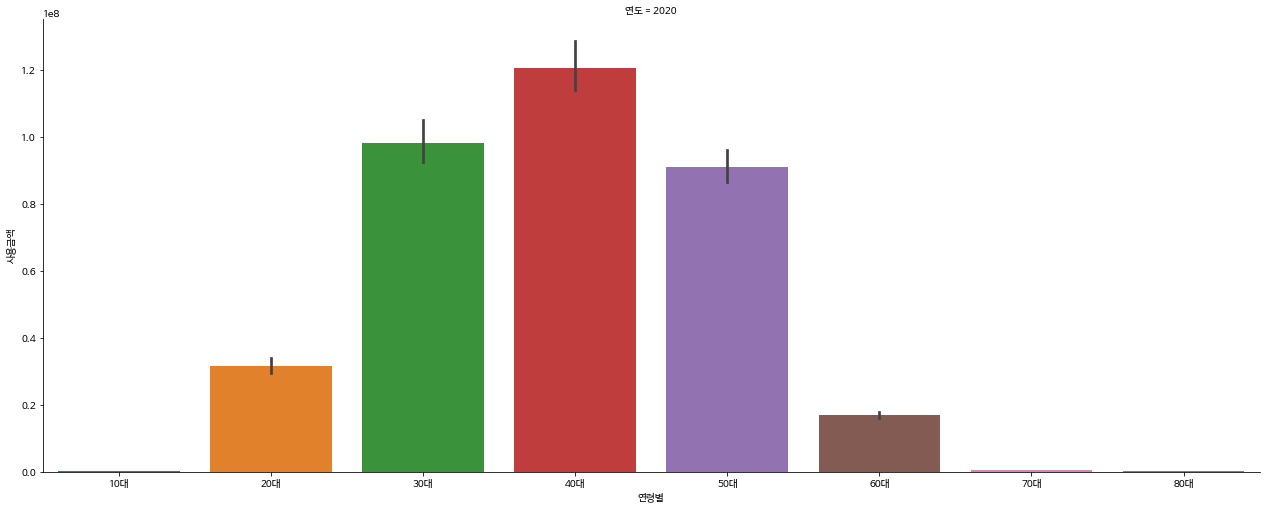

In [ ]:
#연령별 사용금액
sns.catplot(x="연령별", y="사용금액", data=df_total_2019_drop, kind="bar",height=7, aspect=2.5, col="연도")
sns.catplot(x="연령별", y="사용금액", data=df_total_2020_drop, kind="bar",height=7, aspect=2.5, col="연도",order=["10대", "20대", "30대", "40대", "50대", "60대", "70대","80대"])
#bx = plt.subplot()
plt.show()

###### - 2019년 2020년 성별에 따른 연령대별 평균 사용금액 시각화

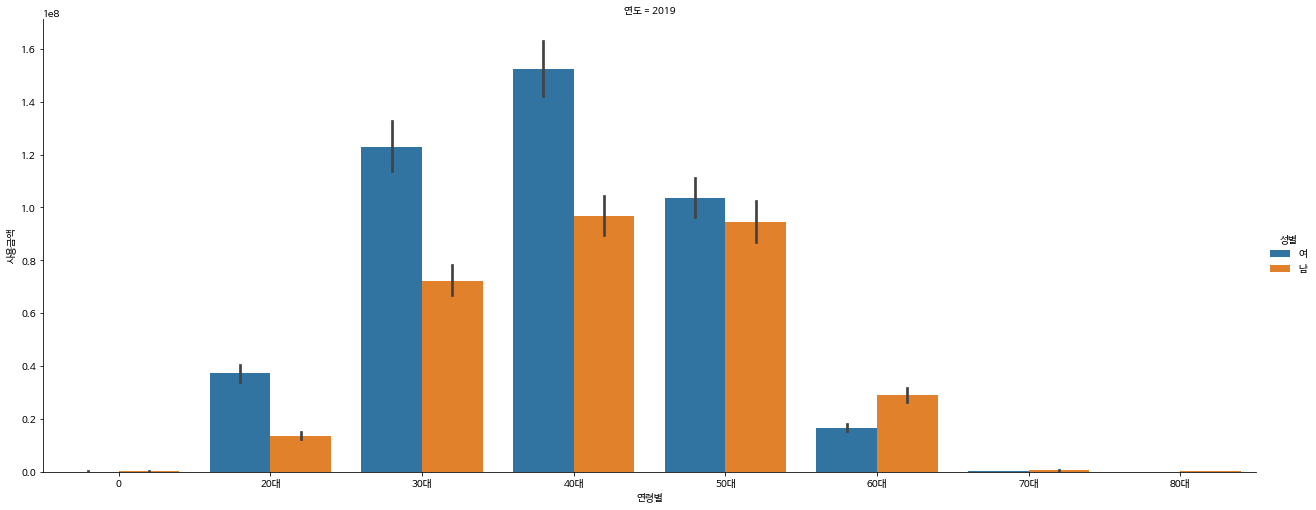

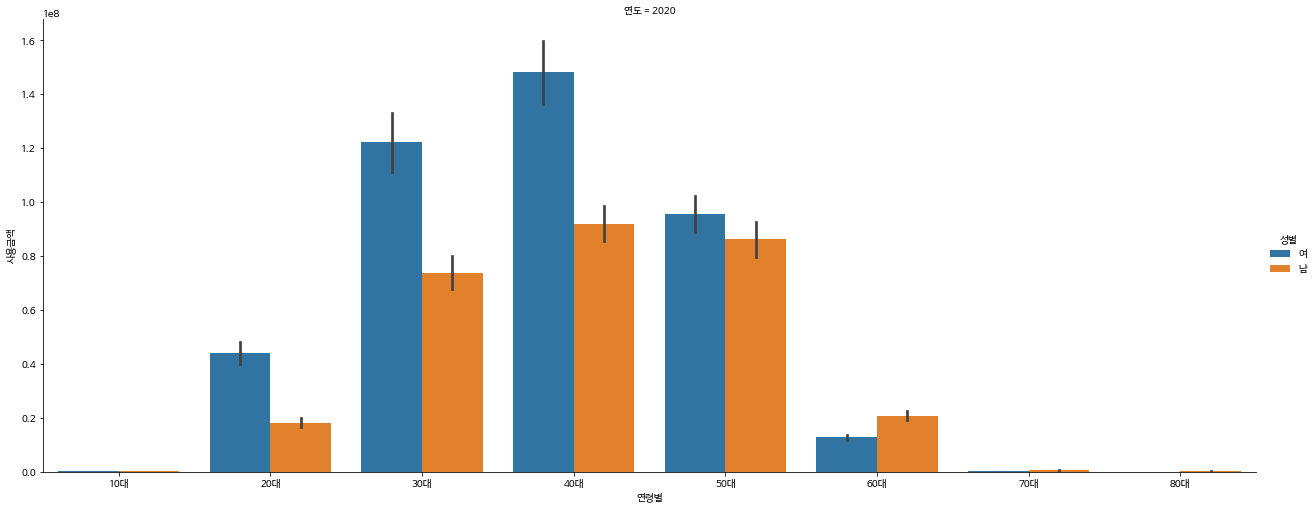

In [ ]:
#연령별 사용금액, 성별 분류
sns.catplot(x="연령별", y="사용금액", data=df_total_2019_drop, hue="성별", kind="bar",height=7, aspect=2.5, col="연도")
sns.catplot(x="연령별", y="사용금액", data=df_total_2020_drop, hue="성별", kind="bar",height=7, aspect=2.5, col="연도",order=["10대", "20대", "30대", "40대", "50대", "60대", "70대","80대"])
plt.show()

###### - 1차분류코드별 연령대에 따른 평균 사용금액 시각화

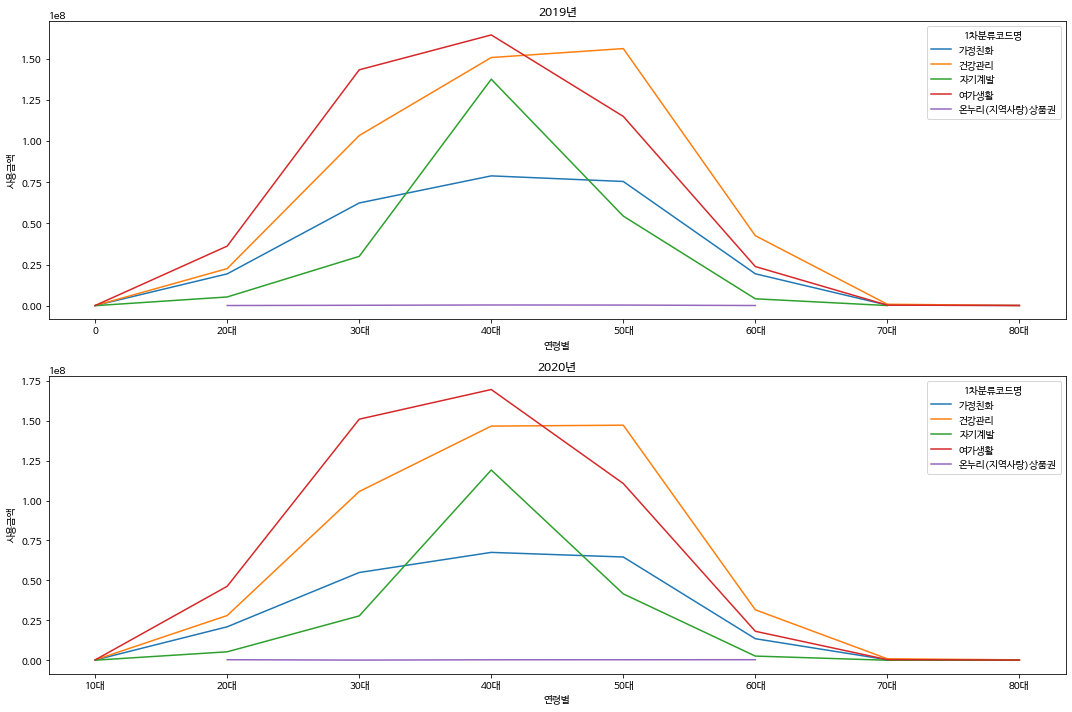

In [ ]:
df_2019_age = df_total_2019_drop.sort_values("연령별")
df_2019_age = df_2019_age[df_2019_age["1차분류코드명"] != "온누리상품권"]
df_2020_age = df_total_2020_drop.sort_values("연령별")

_col = df_2019_age["1차분류코드명"].unique().tolist()

fig = plt.figure(figsize=(15,10))
ax=fig.add_subplot(2,1,1)
ax=sns.lineplot(data=df_2019_age, x="연령별", y="사용금액" ,hue="1차분류코드명",ci=None).set_title("2019년")
ax=fig.add_subplot(2,1,2)
ax=sns.lineplot(data=df_2020_age, x="연령별", y="사용금액" ,hue="1차분류코드명", hue_order=_col, ci=None ).set_title("2020년")

fig.tight_layout()
plt.show()


- 2차 분류코드명별 연령대에 따른 평균 사용금액 시각화 (앞서 I. A. 상위10개 소비품목 사용금액 변화를 시각화해서 굳이 여기서 안다뤄도 될듯

In [ ]:
#df_2019_age = df_total_2019_drop.sort_values("연령별")
#df_2020_age = df_total_2020_drop.sort_values("연령별")

#fig = plt.figure(figsize=(15,26))
#ax = fig.add_subplot(2,1,1)
#ax= sns.lineplot(data=df_2019_age, x="연령별", y="사용금액" ,hue="2차분류코드명",ci=None).set_title("2019년")
#ax = fig.add_subplot(2,1,2)
#ax = sns.lineplot(data=df_2020_age, x="연령별", y="사용금액" ,hue="2차분류코드명",ci=None).set_title("2020년")

#fig.tight_layout()
#plt.show()

In [ ]:
#연령별 사용금액, 성별 분류
#sns.catplot(x="연령별", y="사용금액", data=df_total_2020_drop, hue="성별", kind="bar",height=7, aspect=2.5)
#plt.show()

In [ ]:
#df_2020_age = df_total_2020_drop.sort_values("연령별")

#plt.figure(figsize=(15,10))
#sns.lineplot(data=df_2020_age, x="연령별", y="사용금액" ,hue="1차분류코드명")

In [ ]:
#df_2020_age = df_total_2020_drop.sort_values("연령별")

#plt.figure(figsize=(15,10))
#sns.lineplot(data=df_2020_age, x="연령별", y="사용금액" ,hue="2차분류코드명")

##### B. 2019년 2020년 `성별`별 평균 사용금액 시각화

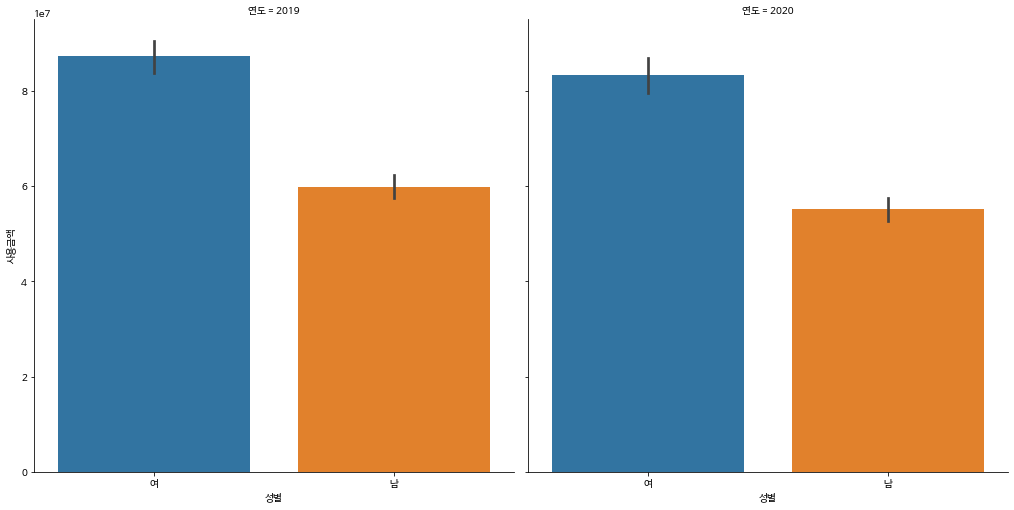

In [ ]:
#성별별 사용금액
sns.catplot(x="성별", y="사용금액", data=df_total, kind="bar",height=7, aspect=1, col ="연도", col_wrap=2)
plt.show()

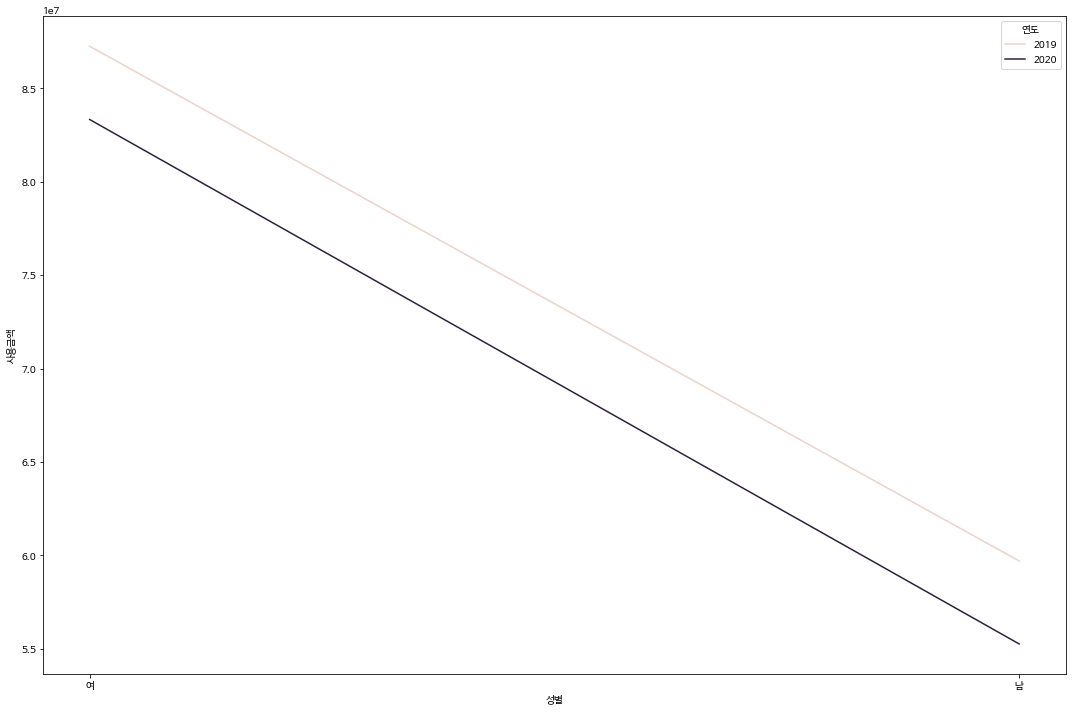

In [ ]:

fig = plt.figure(figsize=(15,10))
ax=sns.lineplot(data=df_total,x="성별", y="사용금액", hue="연도", ci=None)
fig.tight_layout()
plt.show()


In [ ]:
#성별별 사용금액
#sns.catplot(x="성별", y="사용금액", data=df_total_2020_drop, kind="bar",height=7, aspect=1)
#plt.show()

##### C. 2019년 2020년 월별 평균 사용금액 시각화

###### - 2019년 2020년 월별 평균 사용금액 비교

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


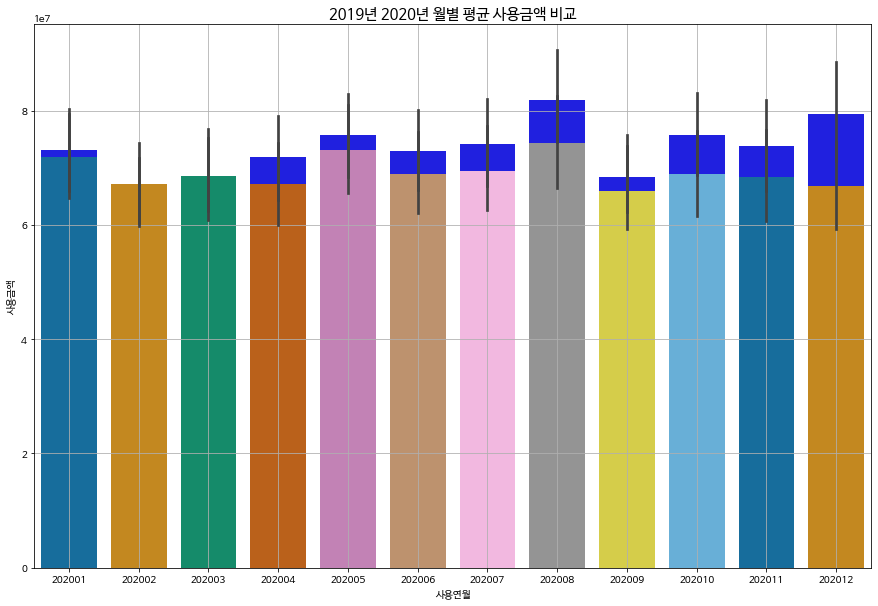

In [ ]:
plt.rcParams["figure.figsize"] = (15, 10)
fig = plt.figure(figsize=(15,10))
plt.title("2019년 2020년 월별 평균 사용금액 비교", fontsize=15)
ax = fig.add_subplot(1,1,1)
ax = sns.barplot(x="사용연월", y="사용금액", data=df_total_2019_drop, color="b")
ax = sns.barplot(x="사용연월", y="사용금액", data=df_total_2020_drop, palette="colorblind")
plt.grid()
plt.show()

In [ ]:
#월별 사용금액
#plt.rcParams["figure.figsize"] = (15, 10)
#sns.barplot(x="사용연월", y="사용금액", data=df_total_2019_drop, palette="colorblind")
#plt.show()

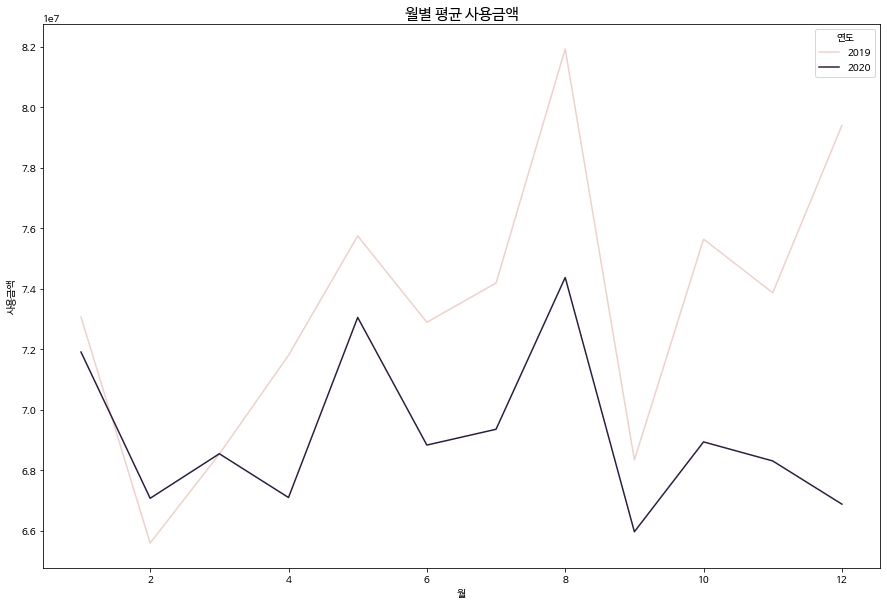

In [ ]:
ax=sns.lineplot(data=df_total,x="월", y="사용금액", hue="연도", ci=None).set_title("월별 평균 사용금액", fontsize=15)

###### - 성별에 따른 월간 평균 사용금액 시각화

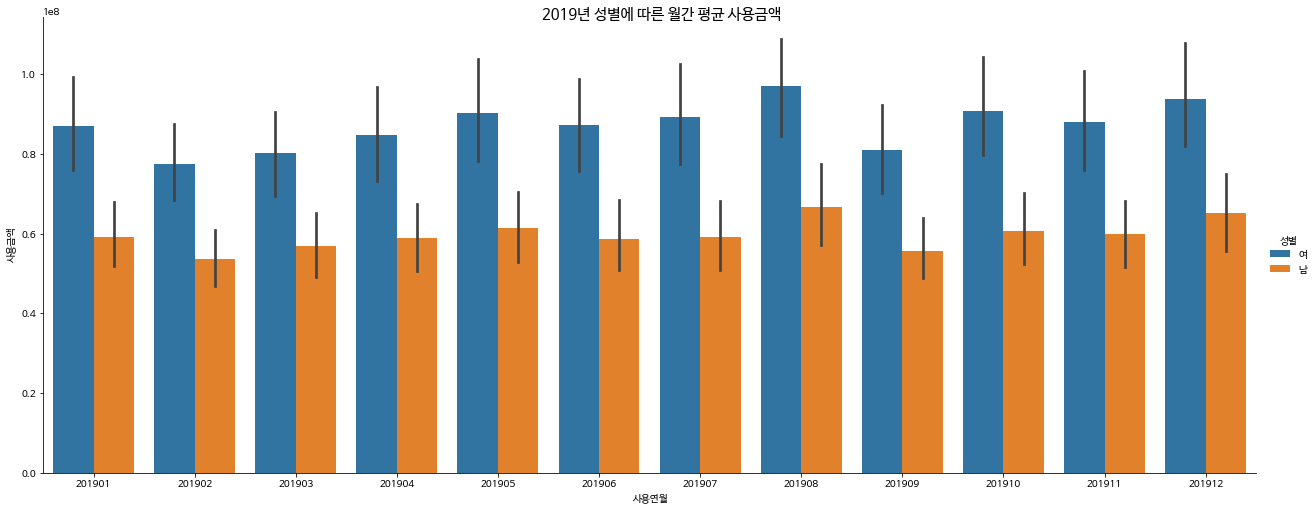

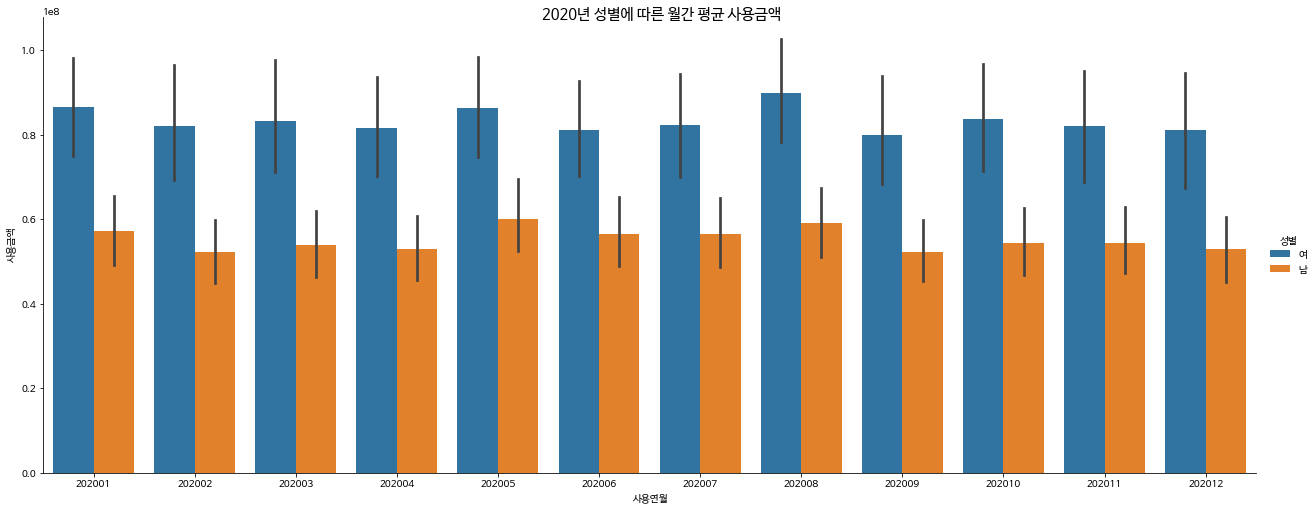

In [ ]:
#월별 사용금액, 성별 분류
ax = sns.catplot(x="사용연월", y="사용금액", hue="성별", data=df_total_2019_drop, kind="bar",height=7, aspect=2.5)
ax.fig.suptitle("2019년 성별에 따른 월간 평균 사용금액", fontsize=15)
ax2 = sns.catplot(x="사용연월", y="사용금액", hue="성별", data=df_total_2020_drop, kind="bar",height=7, aspect=2.5)
ax2.fig.suptitle("2020년 성별에 따른 월간 평균 사용금액", fontsize=15)
plt.show()

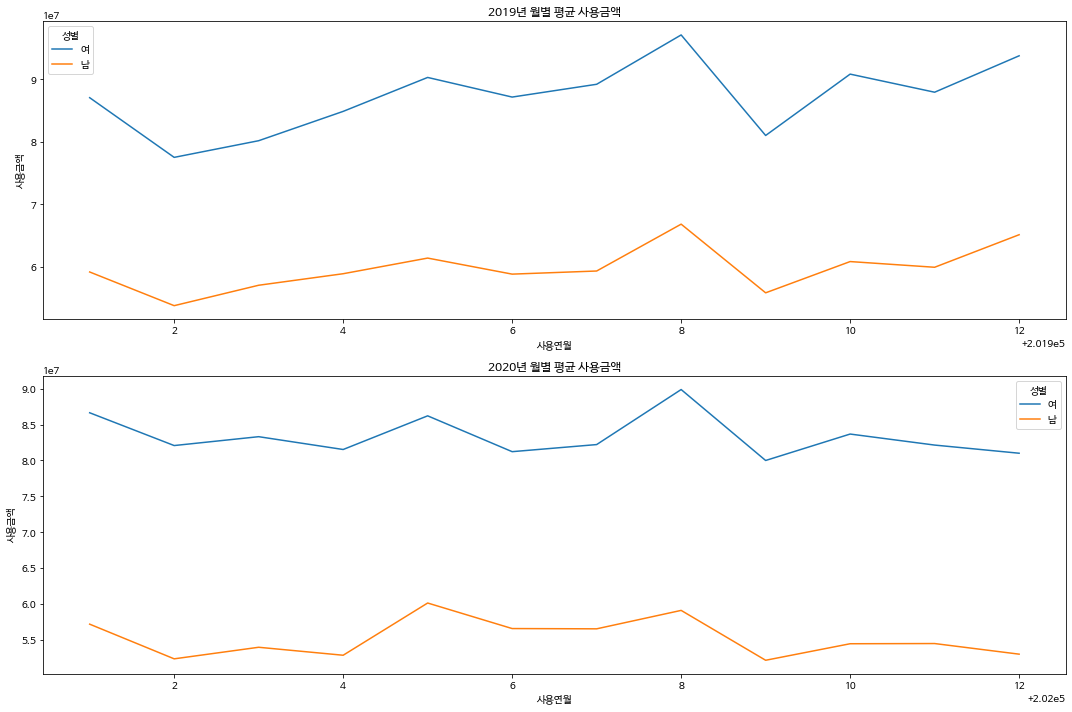

In [ ]:
#월별 사용금액, 성별 분류
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,1,1)
ax = sns.lineplot(x="사용연월", y="사용금액", hue="성별", data=df_total_2019_drop, ci=None).set_title("2019년 월별 평균 사용금액")
ax = fig.add_subplot(2,1,2)
ax = sns.lineplot(x="사용연월", y="사용금액", hue="성별", data=df_total_2020_drop, ci=None).set_title("2020년 월별 평균 사용금액")

fig.tight_layout()
plt.show()

###### - 연령대별 매월 사용건수 시각화

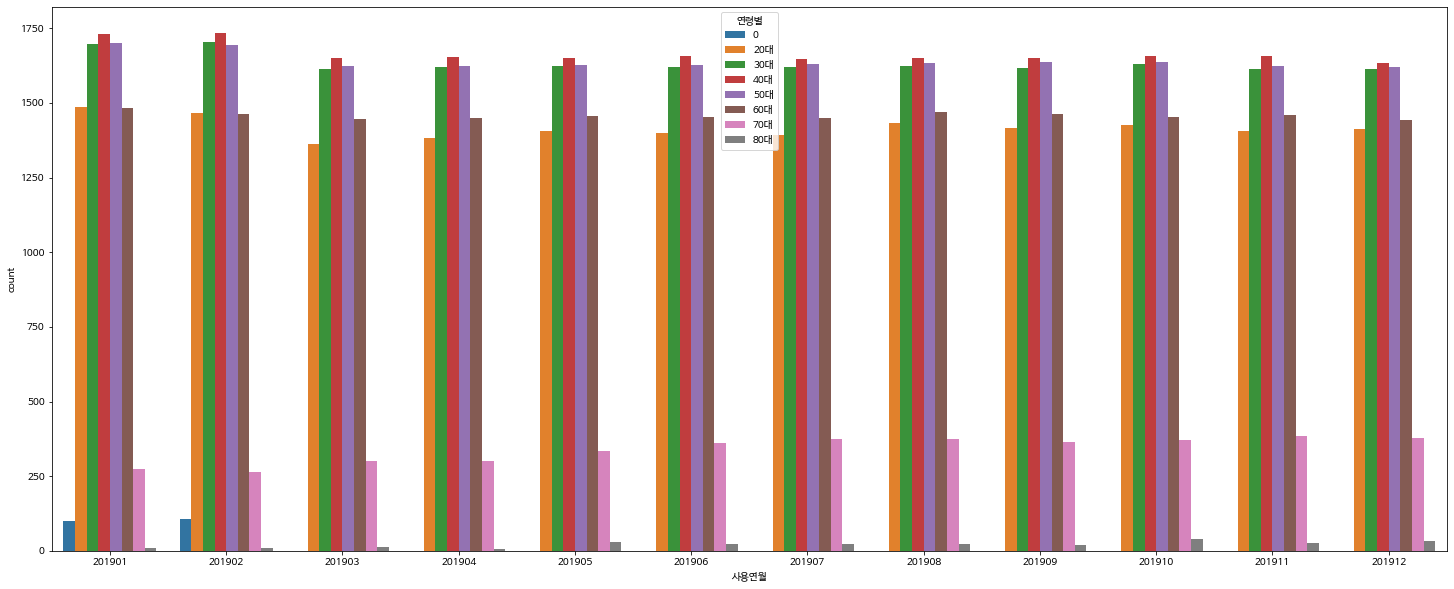

In [ ]:
#월별 row 수, 연령별 분류
plt.rcParams["figure.figsize"] = (25, 10)
sns.countplot(x="사용연월", hue="연령별", data=df_total_2019_drop)
plt.show()

###### 2020년 

In [ ]:
#월별 사용금액
#plt.rcParams["figure.figsize"] = (15, 10)
#sns.barplot(x="사용연월", y="사용금액", data=df_total_2020_drop, palette="colorblind")
#plt.show()

In [ ]:
#월별 사용금액, 성별 분류
#sns.catplot(x="사용연월", y="사용금액", hue="성별", data=df_total_2020_drop, kind="bar",height=7, aspect=2.5)
#plt.show()

##### D. 2차분류별


######2019년


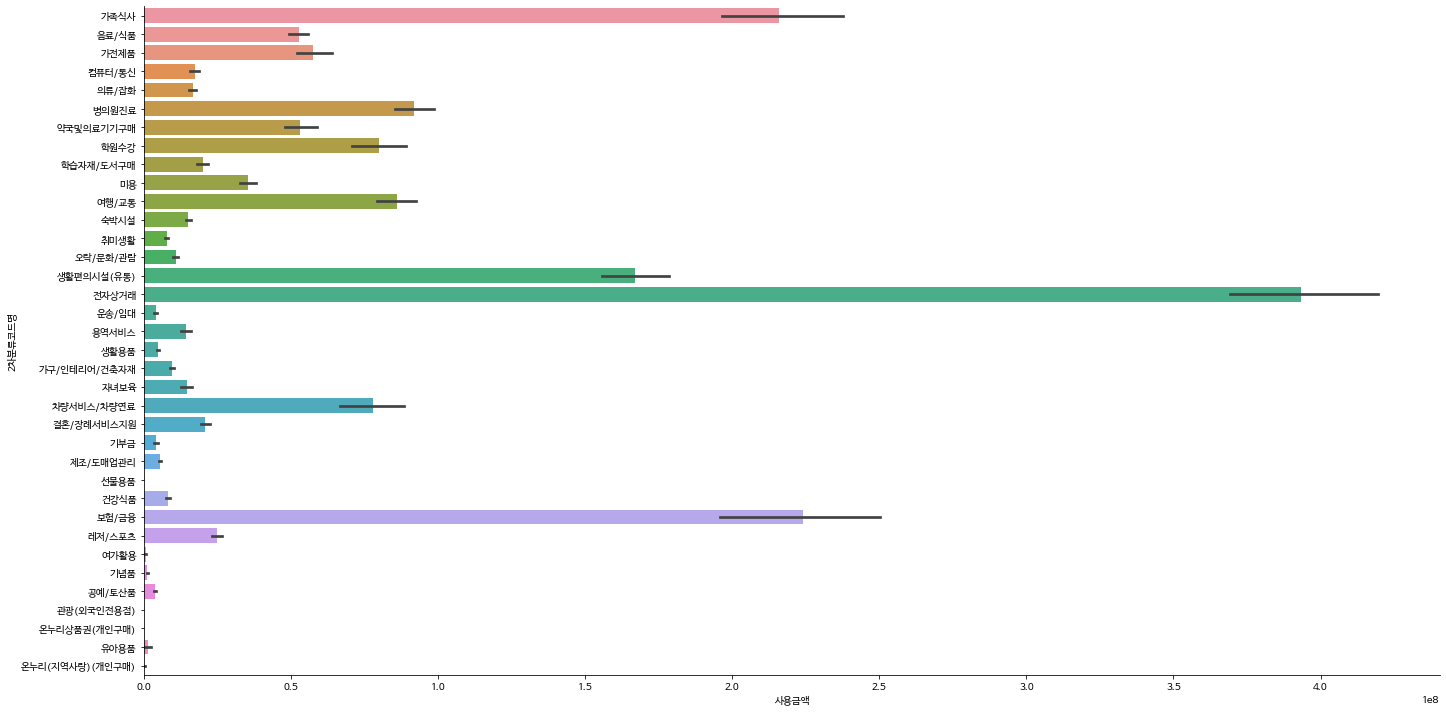

In [ ]:
#2차분류별 사용금액
sns.catplot(x="사용금액", y="2차분류코드명", data=df_total_2019_drop, kind="bar",height=10, aspect=2)
plt.show()

######2020년

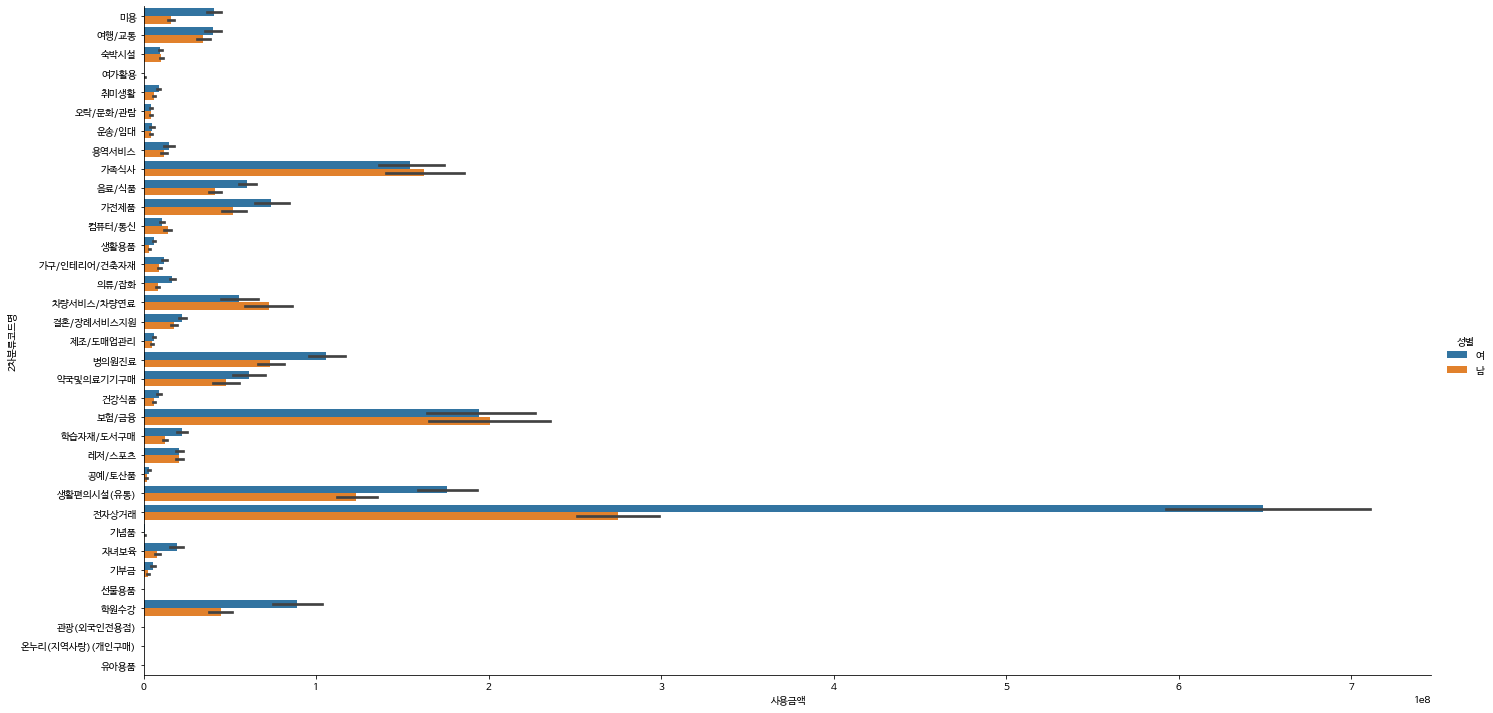

In [ ]:
#2차분류별 사용금액, 성별 분류
sns.catplot(x="사용금액", y="2차분류코드명", data=df_total_2020_drop, hue="성별", kind="bar",height=10, aspect=2)
plt.show()

#### III. 변수 간 상관관계


In [ ]:
df_2019_corr = df_total_2019_drop.corr()
df_2020_corr = df_total_2020_drop.corr()

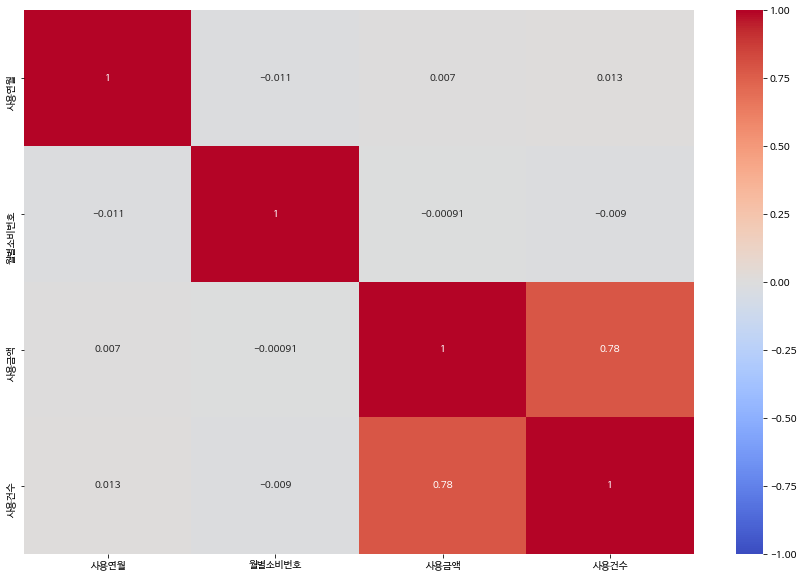

In [ ]:
#수치형 변수간 상관관계
sns.heatmap(df_2019_corr, annot=True, vmax=1, vmin=-1, cmap="coolwarm")

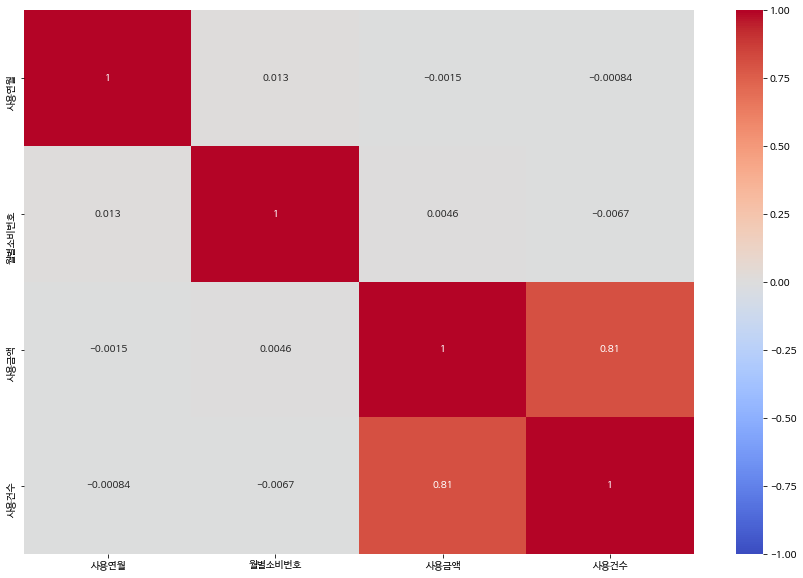

In [ ]:
sns.heatmap(df_2020_corr, annot=True, vmax=1, vmin=-1, cmap="coolwarm")

UFuncTypeError: ignored

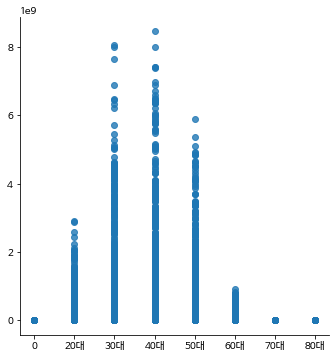

In [ ]:
sns.lmplot(data=df_total_2019_drop, x="연령별", y="사용금액", hue="성별")
#에러 확인 필요(변수 type)

### 추후 추가 및 보완할 시각화 자료


2020년 확진자 수 데이터

In [ ]:
#patient = {"월별확진자수" :{"01월":11," 02월": 3139, "03월": 6636, "04월": 979, "05월":703, "06월":1331, "07월":1506, "08월":5642, "09월":3865, "10월":2699, "11월":7689, "12월":26534}}
#pd_patient = pd.DataFrame(patient)

확진자 수 그래프

In [ ]:
#patient = {"월별확진자수" :{"01월":11,"02월": 3139, "03월": 6636, "04월": 979, "05월":703, "06월":1331, "07월":1506, "08월":5642, "09월":3865, "10월":2699, "11월":7689, "12월":26534}}
#df_patient = pd.DataFrame(patient)
#df_patient

In [ ]:
#df_patient.plot()
#sns.displot(df_patient["월별확진자수"].notnull())

In [ ]:
#plt.rcParams["figure.figsize"] = (15, 10)
#fig = plt.figure(figsize=(15,10))
#plt.title("2019년 2020년 월별 사용금액 비교")
#ax = fig.add_subplot(1,1,1)
#ax = sns.barplot(x="사용연월", y="사용금액", data=df_total_2019_drop, palette="pastel")
#ax = sns.barplot(x="사용연월", y="사용금액", data=df_total_2020_drop, palette="colorblind")
#ax = df_patient.plot()
#plt.grid()
#plt.show()

In [ ]:
#plt.rcParams["figure.figsize"] = (15, 10)
#fig = plt.figure(figsize=(15,10))
#plt.title("2019년 2020년 월별 사용금액 비교")
#ax = fig.add_subplot(1,1,1)
#ax = sns.lineplot(x="사용연월", y="사용금액", data=df_total_2019_drop)
#ax = sns.lineplot(x="사용연월", y="사용금액", data=df_total_2020_drop)
# ax = df_patient.plot()
#plt.grid()
#plt.show()

### 06. 멘토링 



*   본 데이터셋은 시계열적 요소(사용연월)가 들어간 시계열 데이터
*   기초적인 머신러닝 알고리즘(로지스틱회귀 등)은 비시계열 알고리즘
*   시계열 예측(LSTM, CNN 등)을 진행하는 것도 난이도상 어려울 듯


---

질문사항
-시계열 요소가 들어가지 않도록 특정 월 내에서 예측 알고리즘 구현 가능성?

*   수치형 데이터(regression-tree 알고리즘)
*   나머지 데이터(분류코드, 성별, 연령 등) 활용 - 사용금액or건수 예측
* 금액과 건수 사이 상관관계가 높으니 x, y에 각각 분류되어있어야할 듯


---



추후 진행 예정
1.   연도별 소비 비교 분석을 통한 유의미한 인사이트 도출
2. 특정 월 내 비시계열 머신러닝 알고리즘 구현






### 가설 검증

#### - 코로나 확진자 여파에 따라 맞춤형 복지 신용카드 소비가 증가(또는 감소)했을 것이다.

,월별확진자수
월,
1,11
2,3139
3,6636
4,979
5,703


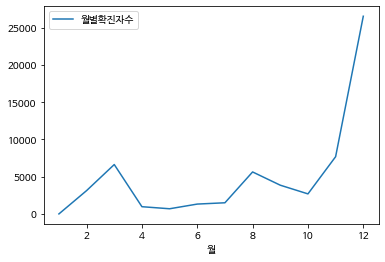

In [26]:
patient = {"월별확진자수" :{1:11,2: 3139, 3: 6636, 4: 979, 5:703, 6:1331, 7:1506, 8:5642, 9:3865, 10:2699, 11:7689, 12:26534}}
df_patient = pd.DataFrame(patient)
df_patient.index.name="월"
df_patient.plot()
#df_patient.info()

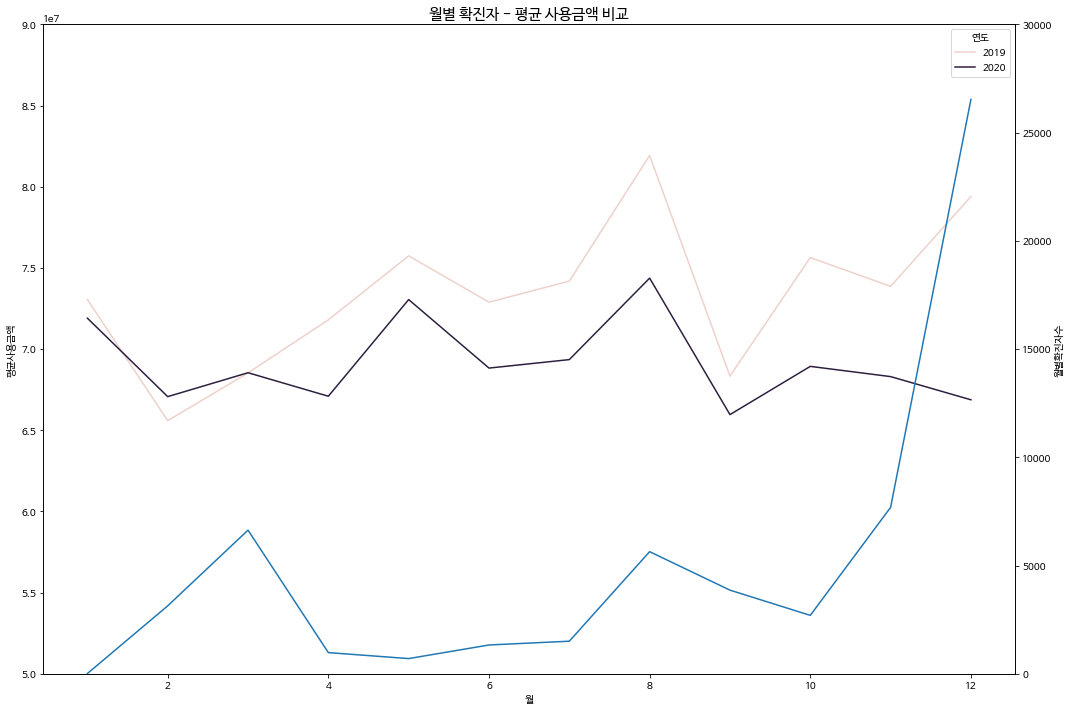

In [42]:
#fig, ax = plt.subplots()
fig = plt.figure(figsize=(15,10))
plt.title("월별 확진자 - 평균 사용금액 비교", fontsize=15)
ax= sns.lineplot(data=df_total,x="월", y="사용금액", hue="연도", ci=None)
ax2= ax.twinx()
sns.lineplot(data=df_patient, x="월", y="월별확진자수", ci=None,ax=ax2)
ax.set_ylabel("평균사용금액")
#ax2.set_ylabel("월별확진자수")
ax.set_ylim(50000000, 90000000 )
ax2.set_ylim(0,30000)
fig.tight_layout()
plt.show()


2020 년 거리두기 단계 
- 5월 6일, 생활 속 거리두기
- 8월 16일, 수도권 2단계
- 8월 23일, 전국 확대
- 8월 30일 ~ 9월 13일, 2.5단계
- 9월 14일 ~ 9월 27일, 2단계
- 10월 12일, 1단계
- 11월 24일, 수도권 2단계 
- 11월 29일, 비수도권 1.5단계
- 12월 8일 ~ 12월 28일 수도권 2.5 단계 비수도권 2단계

(출처 : 위키백과)